In [2]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint
from timer_cm import Timer
import matplotlib.pyplot as plt
from itertools import combinations

In [61]:
class GridNetwork():
    def __init__(self, n, chargers=None):
        self.n = n # Grid size
        self.l = 4*n*(n-1) # Number of total links
    
        # Chargers can be an integer in which case we generate random charger positions
        if type(chargers) == int:
            self.chargers = self.create_random_chargers(chargers)
        else:
            self.chargers = chargers
        self.car_types = ["no charging type"] + ["charging type"]*bool(self.chargers)
        self.charging_to_no_charging_ratio = 0.5
        # add self loop of charger as a link
        if self.chargers:
            self.l += len(self.chargers)
        
        self.d = None # Number of demand constraints
        self.r = None # Number of total routes
        self.grid = np.zeros((n,n))
        if self.chargers is not None:
            for charger_i in self.chargers:
                self.grid[charger_i]=1 
        self.links = []
        self.od_pairs_and_routes = {}
        self.A = None # Demand matrix
        self.R = None # Route flow to link flow conversion matrix (Routing matrix)
        
        # Create all links of the grid
        self.create_links()
        self.objective_count = 0
        self.objective_first_derivative_count = 0
        self.objective_second_derivative_count = 0
        
        self.obj_history = []

    def print_info(self):
        print("Grid size n: ", n, "\nGrid: \n", self.grid)
        if self.chargers: 
            print("Charger Positions: \n", self.chargers)
        print("Number of total links l: ", self.l)
        print("Number of OD pairs d: ", self.d)
        print("Number of routes r: ", self.r)
        print("OD pairs and corresponding routes: \n", self.od_pairs_and_routes)
        print("Routing matrix R: \n", self.R)
        print("Demand matrix A: \n", self.A)
        print("Demands vector b: \n", self.b)
        
    def plot_info(self):
        # Plots the route flows before and after optimization
        plt.plot(self.x0, label='Initial (uniform distributed)')
        plt.plot(self.res.x, label='Optimized')
        plt.xlabel("Route #")
        plt.ylabel("Route flow")
        plt.legend()
        plt.show()
        
        # Plots the link flows before and after optimization
        plt.plot(self.flow, label='Link flows after optimization')
        initial_link_flows = self.R@self.x0
        plt.plot(initial_link_flows, label='Initial link flows')
        plt.xlabel("Link #")
        plt.ylabel("Link flow")
        plt.legend()
        
        """# Plot the charger link
        if self.chargers:
            flow_max = np.max(self.flow)
            for charger_i in self.chargers:
                charger_link_idx = self.links.index((charger_i, (charger_i[0]+1, charger_i[1])))
                plt.vlines(charger_link_idx, 0, flow_max, color='red')
        """
        plt.show()
        
        # Plot the objective function progress during the optimization
        plt.plot(self.obj_history, label='Objective Value')
        plt.xlabel("Iteration")
        plt.ylabel("Objective Value")
        plt.legend()
        
        # Plot link flows
        self.plot_link_flows()
        
    def plot_link_flows(self):
        # Create a figure and axis
        fig, ax = plt.subplots()

        for i, link_i in enumerate(self.links):
            link_i_y0 = self.n - 1 - link_i[0][0]
            link_i_y1 = self.n - 1 - link_i[1][0]
            x = link_i[0][1] + 0.5
            y = link_i_y0 + 0.5 
            dx = link_i[1][1] + 0.5 - x
            dy = link_i_y1 + 0.5 - y
            # create some offset
            if dx != 0:
                dx *= 0.8
            if dy != 0:
                dy *= 0.8
            flow_rate = 0.2*self.flow[i]/np.max(self.flow) # This might be slow
            if dx==0 and dy==0:
                ax.scatter(x, y, c='orange', s=1000*flow_rate)
            else:
                ax.arrow(x + dx/6 + dy/12, y + dy/6 + dx/12, 5*dx/6, 5*dy/6, width = flow_rate, head_length=0.1, head_width=0.1)
            
        for i in range(self.n):
            for j in range(self.n):
                # Plot the grid squares
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, color='black'))
        
        # Set labels and title
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')
        ax.set_title('Link Flows on Grid')

        # Show the plot
        plt.show()
        
    def is_inside_grid_boundary(self, xy):
        x,y = xy
        return not (x < 0 or x > self.n-1 or y < 0 or y > self.n-1)
        
    def create_links(self):
        self.links=[]
        delta = [(0,+1), (+1,0), (0,-1), (-1,0)]
        for i in range(self.n):
            for j in range(self.n):
                for (dx, dy) in delta:
                    xy = (i+dx, j+dy)
                    if self.is_inside_grid_boundary(xy):
                        self.links.append(((i,j), xy))
        # Create a self loop for charger
        if self.chargers:
            for charger_i in self.chargers:
                self.links.append((charger_i, charger_i)) 
                
    def create_random_chargers(self, c):
        chargers = set()
        while len(chargers)!=c:
            chargers.add(tuple(np.random.randint(0, self.n, 2)),)
        return chargers
                        
    def path_n_s_e_w(self, od_pair):
        ((x1, y1), (x2, y2)) = od_pair
        path = []

        while x1-x2 != 0:
            path.append((x1, y1))
            x1 -= np.sign(x1-x2)

        while y1-y2 != 0:
            path.append((x1, y1))
            y1 -= np.sign(y1-y2)

        path.append((x2, y2))
        return tuple(path)
    
    def path_e_w_n_s(self, od_pair):
        ((x1, y1), (x2, y2)) = od_pair
        path = []
        
        while y1-y2 != 0:
            path.append((x1, y1))
            y1 -= np.sign(y1-y2)

        while x1-x2 != 0:
            path.append((x1, y1))
            x1 -= np.sign(x1-x2)

        path.append((x2, y2))
        return tuple(path)
    
    def path_zigzag_n_s_e_w(self, od_pair):
        ((x1, y1), (x2, y2)) = od_pair
        path = []

        while x1-x2 != 0 or y1-y2 != 0:
            if (x1-x2 != 0):
                path.append((x1, y1))
                x1 -= np.sign(x1-x2)
            if (y1-y2 != 0):
                path.append((x1, y1))
                y1 -= np.sign(y1-y2)

        path.append((x2, y2))
        return tuple(path)
    
    def path_zigzag_e_w_n_s(self, od_pair):
        ((x1, y1), (x2, y2)) = od_pair
        path = []

        while x1-x2 != 0 or y1-y2 != 0:
            if (y1-y2 != 0):
                path.append((x1, y1))
                y1 -= np.sign(y1-y2)
                
            if (x1-x2 != 0):
                path.append((x1, y1))
                x1 -= np.sign(x1-x2)

        path.append((x2, y2))
        return tuple(path)
    
    def create_OD_paths(self, od_pair):
        # creates different paths for the given OD pair
        # 1. go n-s and then go e-w
        # 2. go e-w and then go n-s
        # 3. zigzag n-s priority
        # 4. zigzag e-w priority
        # crate a set to remove redundancies in paths
        paths = set()
        paths.add(self.path_n_s_e_w(od_pair))
        paths.add(self.path_e_w_n_s(od_pair))
        paths.add(self.path_zigzag_n_s_e_w(od_pair))
        paths.add(self.path_zigzag_e_w_n_s(od_pair))
        n_paths = len(paths)
        return paths, n_paths
    
    def create_OCD_paths(self, od_pair):
        # creates different paths that go through the carger for the given OD pair
        # crate a set to remove redundancies in paths
        ocd_paths = set()
        ((xo, yo), (xd, yd)) = od_pair
        for charger_i in self.chargers:
            (xc, yc) = charger_i
            oc_pair = ((xo, yo), (xc, yc))
            cd_pair = ((xc, yc), (xd, yd))

            oc_paths, _ = self.create_OD_paths(oc_pair)
            cd_paths, _ = self.create_OD_paths(cd_pair)

            for oc_paths_i in oc_paths:
                for cd_paths_j in cd_paths:
                    # Notice this accounts for the self loop at the charger
                    ocd_paths.add(oc_paths_i + cd_paths_j)
        n_paths = len(ocd_paths)
        return ocd_paths, n_paths
        
    def get_od_pairs_and_demands(self, od_pairs, demands):
        if self.chargers is not None:
            self.d = int(len(demands)/2)
        else:
            self.d = len(demands)
        # create b
        self.b = demands
        # create routes
        n_paths_total = 0
        for od_pair in od_pairs:
            self.od_pairs_and_routes[od_pair] = {}
            self.od_pairs_and_routes[od_pair]["no charging type"], n_paths_i = self.create_OD_paths(od_pair)
            n_paths_total += n_paths_i
            if self.chargers:
                self.od_pairs_and_routes[od_pair]["charging type"], n_paths_i = self.create_OCD_paths(od_pair)
                n_paths_total += n_paths_i
                
        # Create A and R
        self.r = n_paths_total
        self.A = np.zeros((2*self.d, self.r),  dtype=int)
        self.R = np.zeros((self.l, self.r),  dtype=int)
        route_idx = 0
        for i, od_pair in enumerate(self.od_pairs_and_routes.keys()):
            for c, car_type in enumerate(self.car_types):
                od_pair_routes = self.od_pairs_and_routes[od_pair][car_type]
                t = len(od_pair_routes)
                self.A[2*i+c][route_idx:route_idx+t] = 1
                for j, od_pair_route_j in enumerate(od_pair_routes):
                    for k, route_j_elem in enumerate(od_pair_route_j):
                        if k == len(od_pair_route_j)-1:
                            break
                        link_idx = self.links.index((route_j_elem, od_pair_route_j[k+1]))
                        self.R[link_idx][route_idx+j] = 1
                route_idx += t
            
    def create_random_od_pairs_and_demands(self, d = 3):
        # Create a random demand for charging and no charging cars
        demands = np.random.randint(1, 10, size=2*d)
        for i in range(1, len(demands), 2):
            demands[i] = round(demands[i] * self.charging_to_no_charging_ratio)
        od_pairs = set()
        while(len(od_pairs) < d): 
            origin = (np.random.randint(0, self.n), np.random.randint(0, self.n))
            destination = (np.random.randint(0, self.n), np.random.randint(0, self.n))
            if  origin!=destination:
                od_pairs.add((origin,destination))
        self.od_pairs = od_pairs
        self.b = demands
        self.get_od_pairs_and_demands(od_pairs, demands)
        
    def travel_time_function(self, x, fft=1):
        # BPR function
        a = 1
        b = 1
        c = 2
        return (a * (x / b) ** c)  + (fft + 1)
    
    def potential(self, x, fft=1):
        # BPR function
        a = 1
        b = 1
        c = 2
        return ((a * (x / b) ** c) / (c + 1) + fft) * x
    
    def potential_first_derivative(self, x, fft=1):
        # BPR function derivative
        a = 1
        b = 1
        c = 2
        return (a * (x / b) ** c) + fft
    
    def potential_second_derivative(self, x, fft=1):
        # BPR function second derivative
        a = 1
        b = 1
        c = 2
        return a * c / b * (x / b) ** (c-1)
    
    # Define the objective function
    def objective(self, x):
        self.objective_count += 1
        #print(" ")
        #with Timer('Objective Step: {}'.format(self.objective_count)) as timer:
        self.flow = np.dot(self.R, x)
        self.obj = np.sum(self.potential(self.flow))
        #print("Objective: ", self.obj)
        return self.obj
    
    # Define the travel time objective function
    def travel_time_objective(self):
        self.travel_time_obj = self.flow @ self.travel_time_function(self.flow)
        return self.travel_time_obj
    
    # Define the first derivative of the objective function
    def objective_first_derivative(self, x):
        self.objective_first_derivative_count += 1
        #print(" ")
        #with Timer('Objective First Derivative Step: {}'.format(self.objective_first_derivative_count)) as timer:
        self.flow = np.dot(self.R, x)
        derivatives_vec = self.potential_first_derivative(self.flow)
        first_der =  self.R.T@derivatives_vec
        return first_der
    
    # Define the second derivative of the objective function
    def objective_second_derivative(self, x):
        self.objective_second_derivative_count += 1
        #print(" ")
        #with Timer('Objective Second Derivative Step: {}'.format(self.objective_second_derivative_count)) as timer:
        self.flow = np.dot(self.R, x)
        second_derivatives_vec = self.potential_second_derivative(self.flow)
        second_der =  self.R.T@np.diag(second_derivatives_vec)@self.R
        return second_der
    
    def optimization_callback(self, x, intermediate_result):
        # Callback function to create a history of objective values
        self.obj_history.append(intermediate_result.fun)
    
    def optimize(self, use_derivatives = True, disp=True):
        repetitions = np.sum(self.A, axis = 1)
        equal_divider = np.divide(self.b,  repetitions)
        # Create x0 as dividing the demand uniformly on corresponding paths
        self.x0 = np.zeros(self.r)
        j=0
        for i, repeat_i in enumerate(repetitions):
            self.x0[j:j+repeat_i] = equal_divider[i]
            j += repeat_i
        # Define the bounds for the link flows
        bounds = [(0, None) for _ in range(self.r)]
        lc = LinearConstraint(self.A, self.b, self.b)
        # Either use the derivatives or not
        if use_derivatives:
            self.res = minimize(self.objective, self.x0,
                                jac=self.objective_first_derivative, hess=self.objective_second_derivative,
                                bounds=bounds, constraints=lc, 
                                method="trust-constr", options={'disp': disp, 'maxiter': 100},
                                callback = self.optimization_callback)
        else:
            self.res = minimize(self.objective, self.x0,
                                bounds=bounds, constraints=lc, 
                                method="trust-constr", options={'disp': disp, 'maxiter': 100},
                                callback = self.optimization_callback)
        # Calculate the travel time objective
        self.travel_time_objective()    
            
def outer_optimization(n, d=None, num_chargers=None, possible_charger_positions=None, od_pairs = None, demands=None):
    # Greedy optimization by positioning chargers one by one
    grids = [] # array of grids with different chargers
    dummy_grid = GridNetwork(n)
    # create OD pairs and demands only one time and use it on each network
    if od_pairs is None or demands is None:
        dummy_grid.create_random_od_pairs_and_demands(d)
    if od_pairs is None:
        od_pairs = dummy_grid.od_pairs
    if demands is None:
        demands = dummy_grid.b
        
    # if possible charger_positions given as a number n, produce n random positions
    if type(possible_charger_positions) == int:
        possible_charger_positions = dummy_grid.create_random_chargers(possible_charger_positions)
        
    # Create chargers on different positions
    # First we do greedy optimization and then test the remaining charger_positions
    chargers_set = set()
    best_charger = None
    possible_charger_positions_j = possible_charger_positions.copy()
    for num_chargers_j in range(1, num_chargers+1):
        best_charger_position_j = None
        best_charger_position_travel_time = 1e100
        for charger_ji in possible_charger_positions_j:
            if best_charger is None:
                chargers_i = (charger_ji,)
            else:
                chargers_i = (best_charger) + (charger_ji,)
            chargers_set.add(chargers_i)
            grid_i = GridNetwork(n, chargers=chargers_i)
            grid_i.get_od_pairs_and_demands(od_pairs, demands)
            #grid_i.print_info()
            grid_i.optimize()
            grid_i.plot_info()
            grids.append(grid_i)
            
            if grid_i.travel_time_obj < best_charger_position_travel_time:
                best_charger_position_travel_time = grid_i.travel_time_obj
                best_charger_position_j = chargers_i
        best_charger = best_charger_position_j
        possible_charger_positions_j.remove(best_charger[-1])
                
    plot_travel_time_objectives(grids)
    print("Possible charger positions: ", possible_charger_positions)
    
    return grids

def plot_travel_time_objectives(grids):
    min_obj = 1e9
    min_idx = -1
    for i, grid_i in enumerate(grids):
        obj_i = grid_i.travel_time_obj
        if obj_i < min_obj:
            min_obj = obj_i
            min_idx = i
        plt.scatter(i, grid_i.travel_time_obj, label = str(grid_i.chargers))
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Travel Time Objective')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    print("Min Travel Time: ", min_obj, 'using chargers: ', grids[min_idx].chargers)
    

In [ ]:
n = 3 # grid size
d = 5 # number of OD pairs
chargers = ((1,1), (1,2))
myGrid = GridNetwork(n, chargers=3)
myGrid.create_random_od_pairs_and_demands(d=d)
myGrid.print_info()

In [ ]:
myGrid.optimize()

In [17]:
((1,0),) + ((1,1),)

((1, 0), (1, 1))

In [ ]:
myGrid.plot_info()

## Small experiment

In [63]:
n=3
num_chargers=3
possible_charger_positions = [((1,0)), ((1,1)), ((1,2))]
od_pairs = {((0, 0), (2, 2)), ((0, 1), (2, 1)), ((0, 2), (2, 0)), ((2, 2), (0, 0))}
demands = [4, 2, 8, 3, 9, 2, 10, 3]

`gtol` termination condition is satisfied.
Number of iterations: 40, function evaluations: 38, CG iterations: 305, optimality: 3.93e-09, constraint violation: 4.44e-16, execution time: 0.047 s.


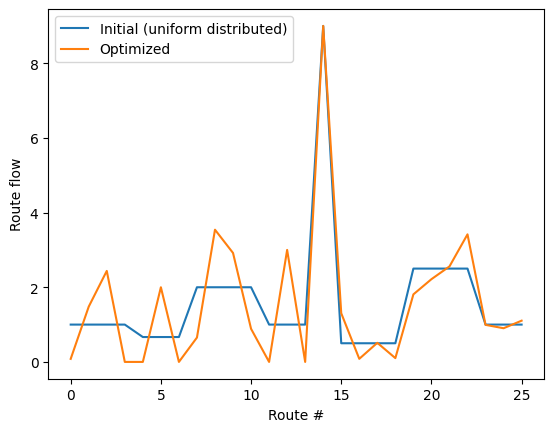

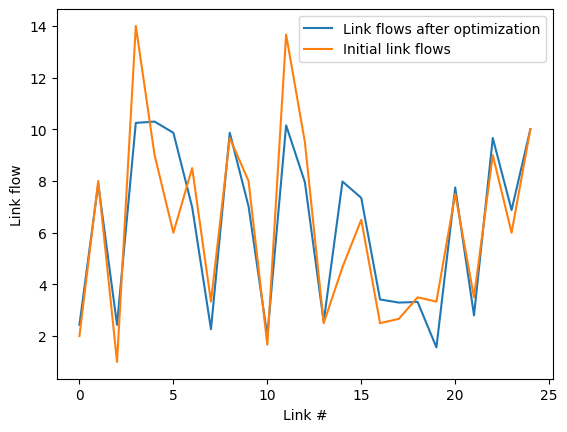

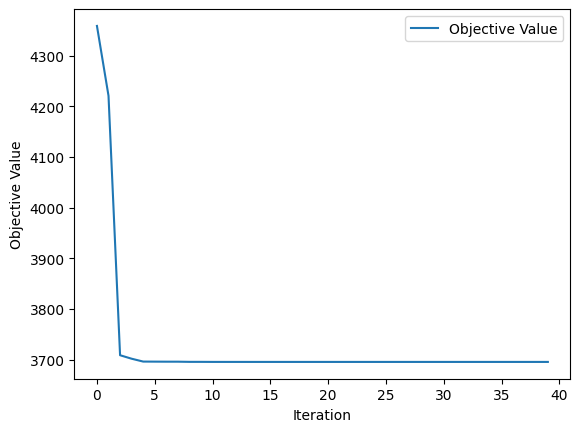

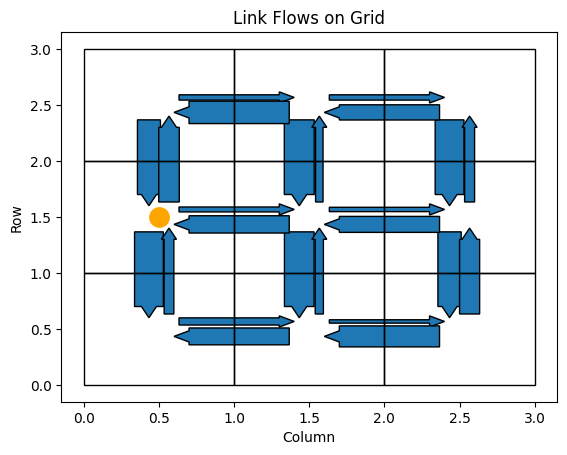

`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 21, CG iterations: 122, optimality: 3.83e-09, constraint violation: 4.44e-16, execution time: 0.025 s.


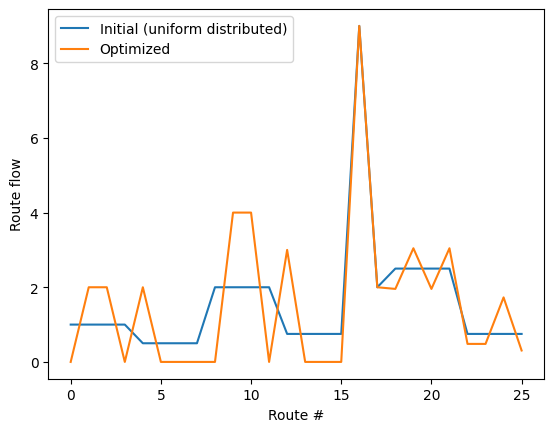

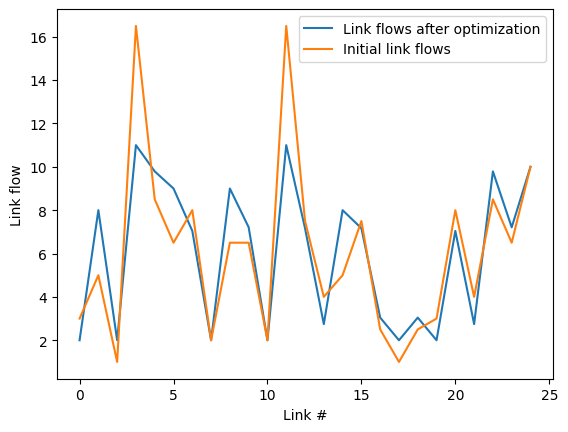

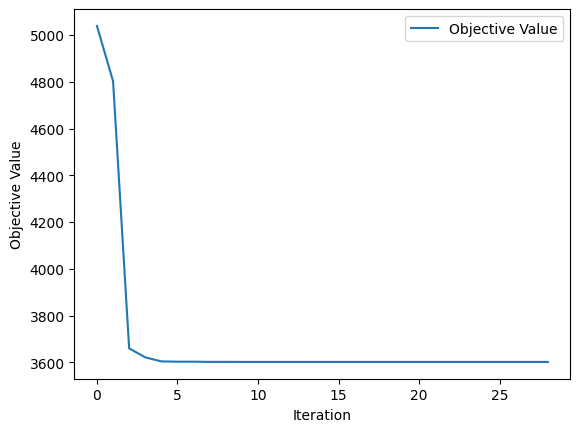

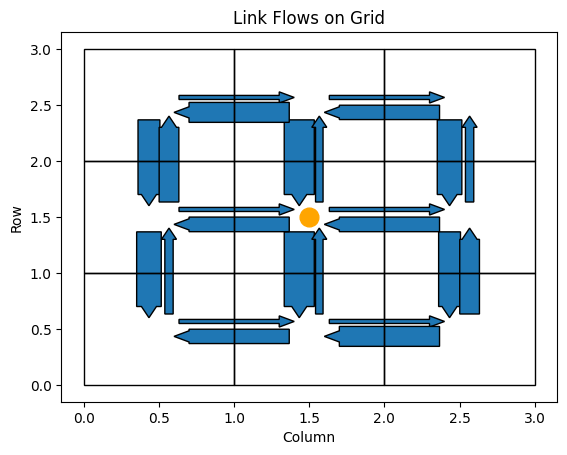

`gtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 19, CG iterations: 169, optimality: 6.33e-09, constraint violation: 4.44e-16, execution time: 0.028 s.


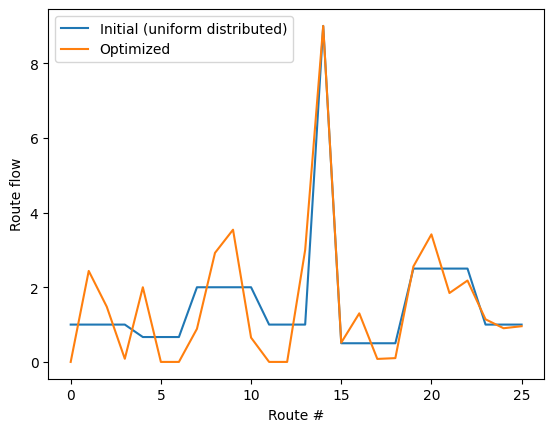

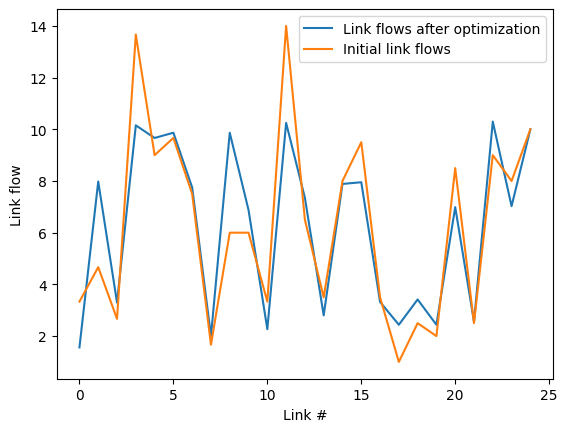

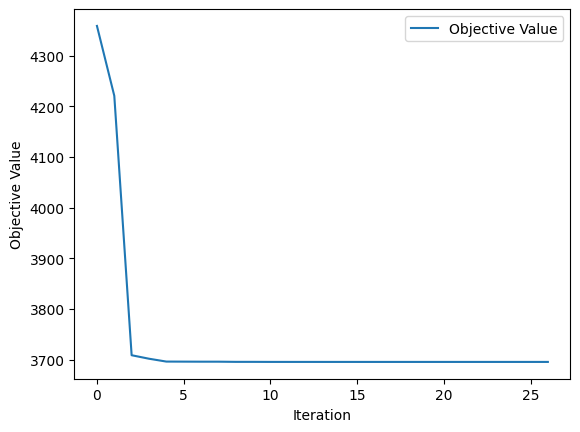

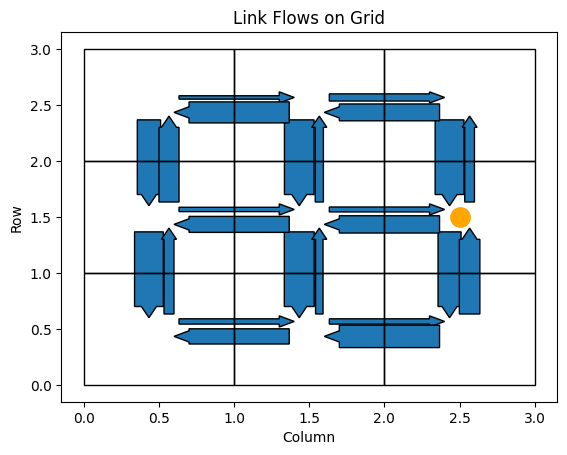

`gtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 24, CG iterations: 167, optimality: 2.40e-09, constraint violation: 8.88e-16, execution time: 0.04 s.


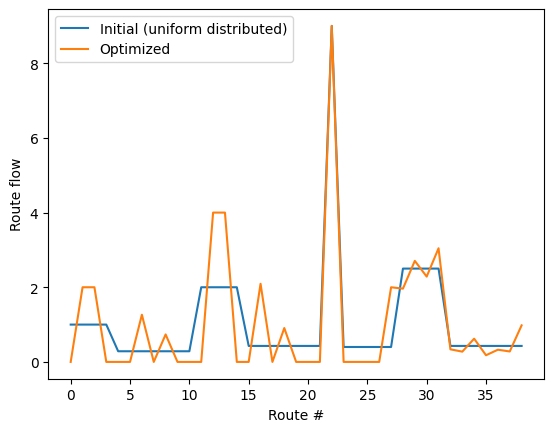

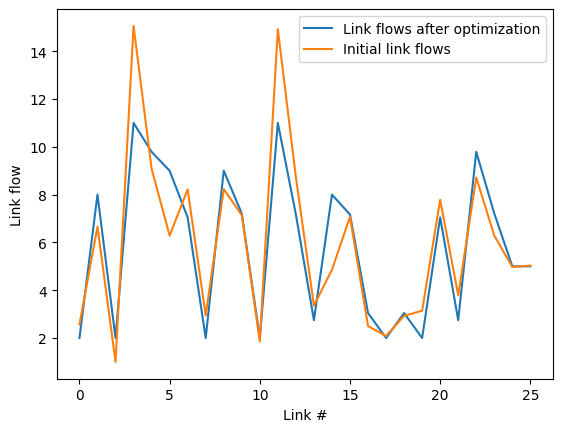

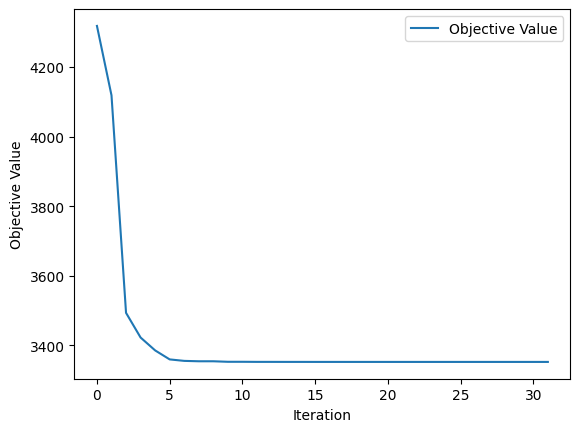

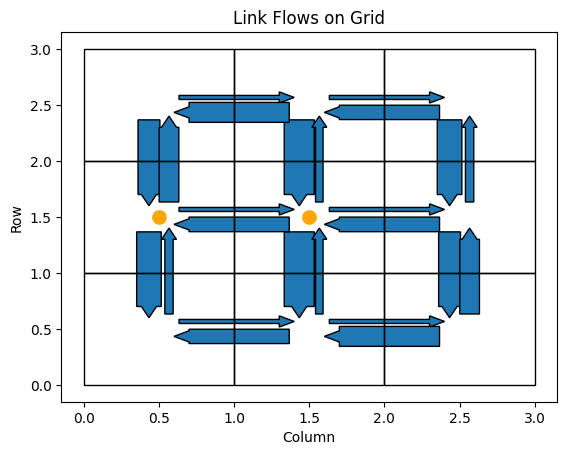

`gtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 24, CG iterations: 169, optimality: 2.40e-09, constraint violation: 4.44e-16, execution time: 0.033 s.


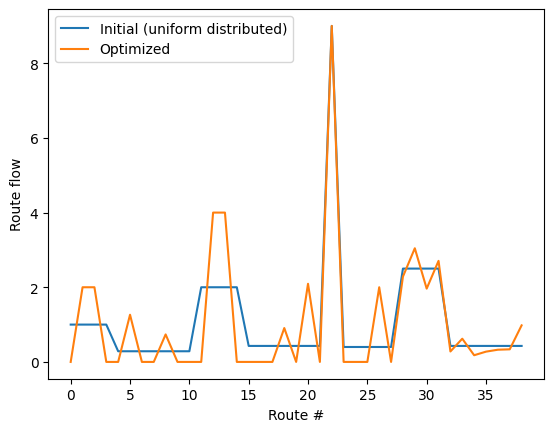

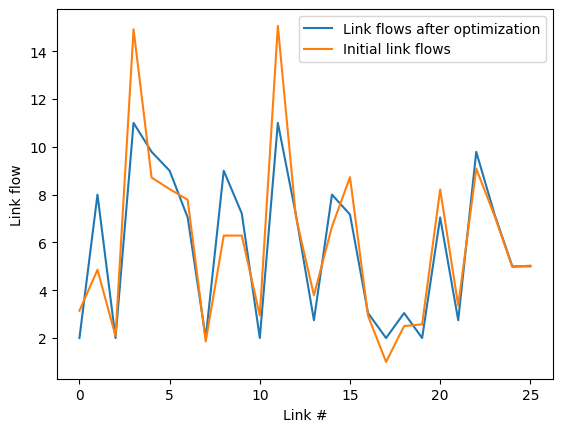

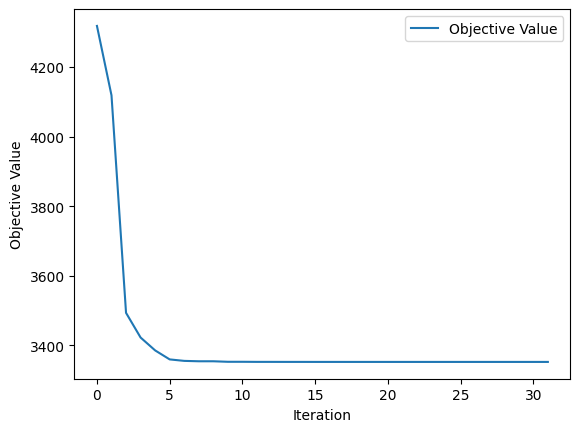

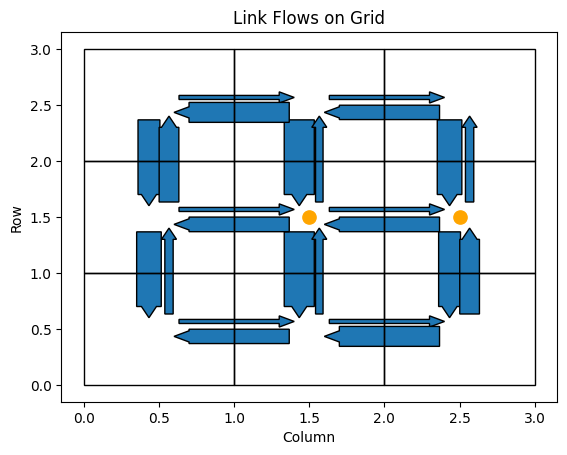

`gtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 23, CG iterations: 171, optimality: 1.93e-10, constraint violation: 3.55e-15, execution time: 0.037 s.


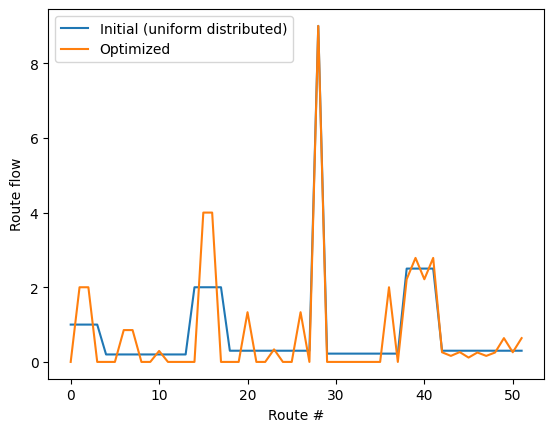

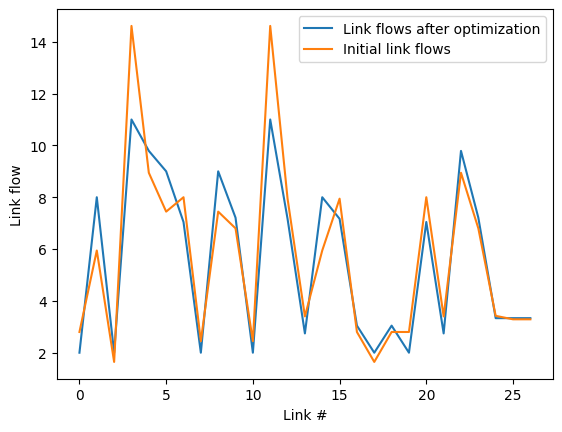

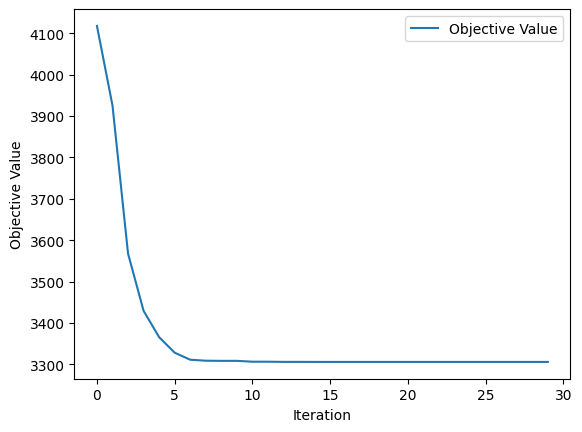

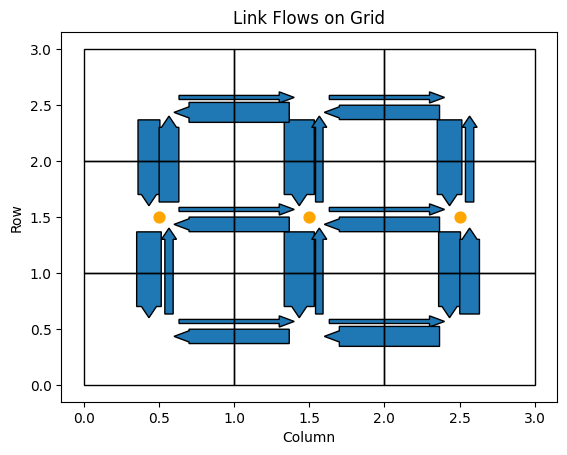

Min Travel Time:  9766.160765566447 using chargers:  ((1, 1), (1, 0), (1, 2))
Possible charger positions:  [(1, 0), (1, 1), (1, 2)]


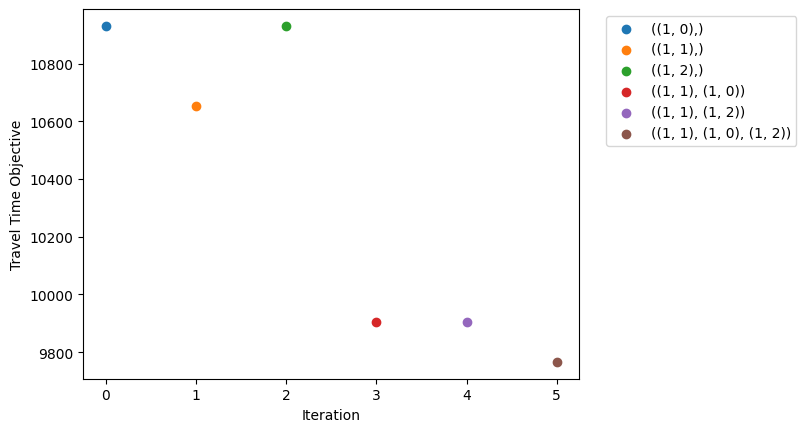

In [64]:
grids1 = outer_optimization(n=n, possible_charger_positions=possible_charger_positions, num_chargers=num_chargers, od_pairs=od_pairs, demands=demands)

## Large experiment

In [54]:
n=5
d=8
num_chargers=4
possible_charger_positions = 10

((4, 4),)
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 84, CG iterations: 463, optimality: 7.19e-03, constraint violation: 3.11e-15, execution time: 0.15 s.


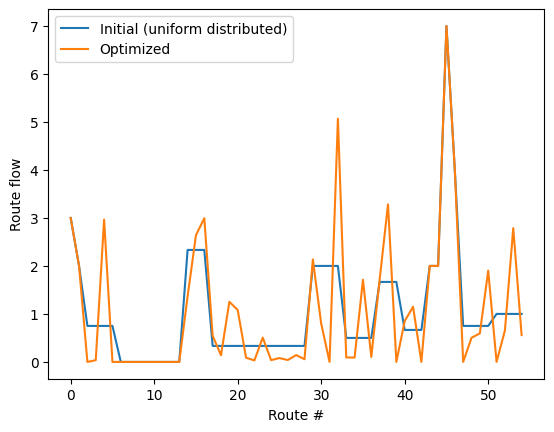

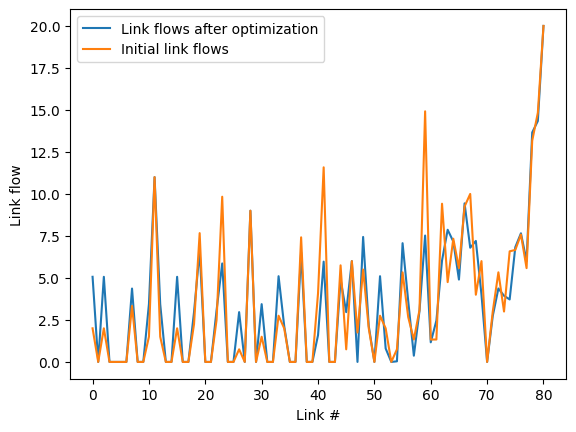

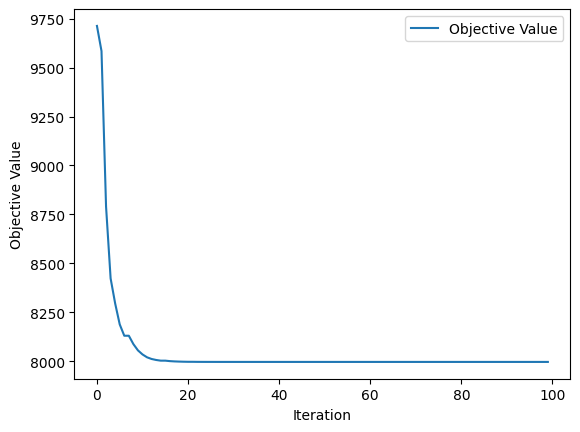

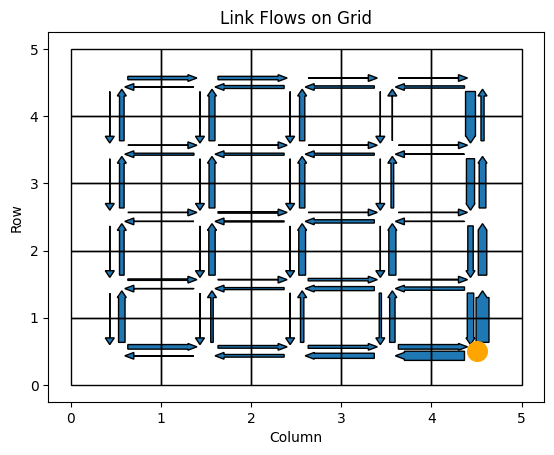

((1, 3),)


/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


`gtol` termination condition is satisfied.
Number of iterations: 91, function evaluations: 82, CG iterations: 728, optimality: 7.28e-09, constraint violation: 8.88e-16, execution time: 3.8e+01 s.


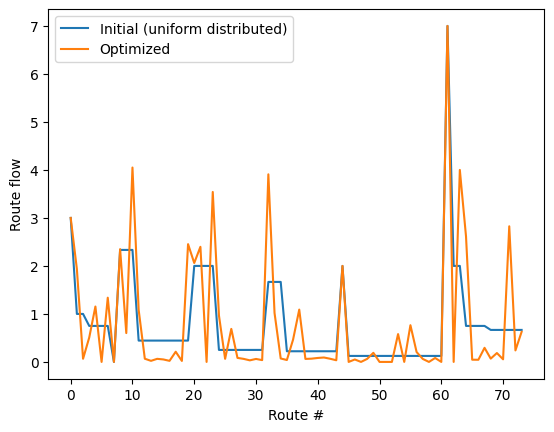

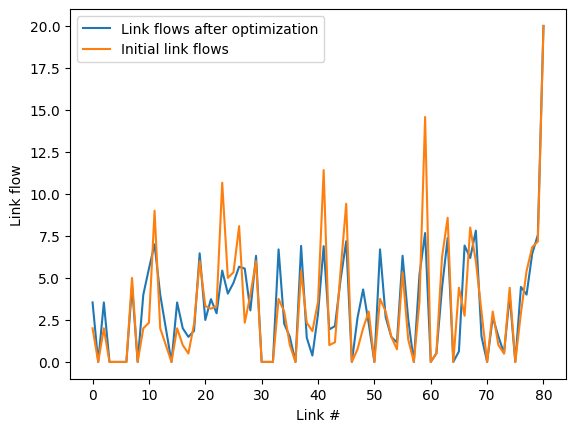

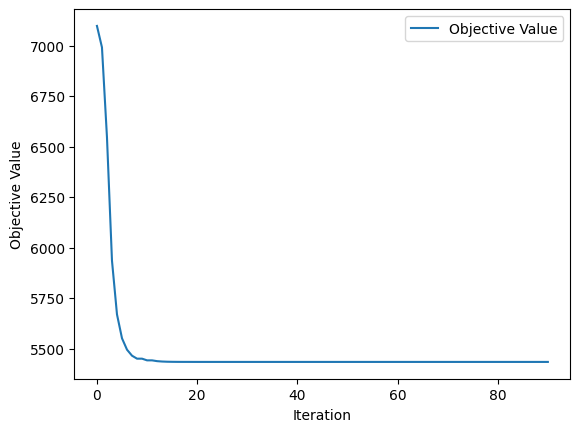

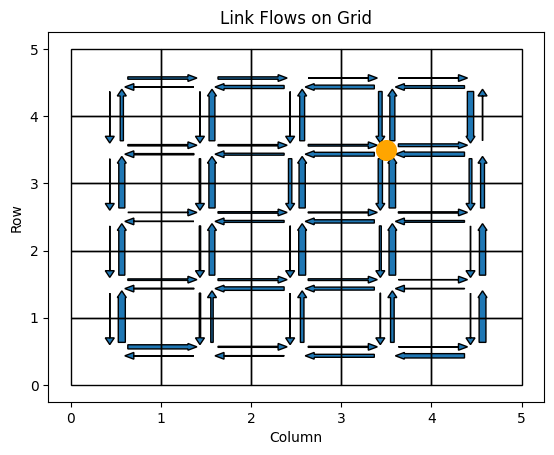

((0, 1),)
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 84, CG iterations: 546, optimality: 1.22e-03, constraint violation: 4.05e-15, execution time: 4.3e+01 s.


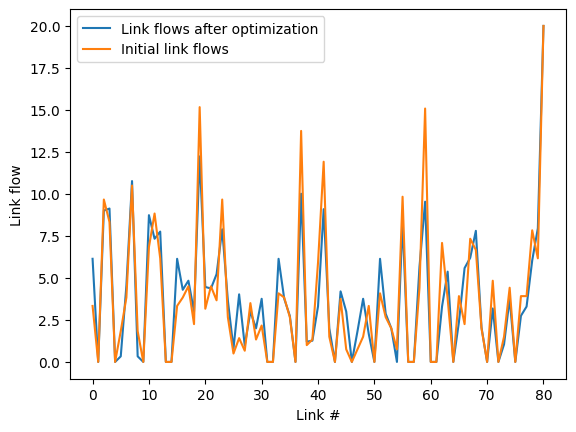

((3, 1),)
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 82, CG iterations: 481, optimality: 5.44e-05, constraint violation: 2.61e-15, execution time: 3.4e+01 s.


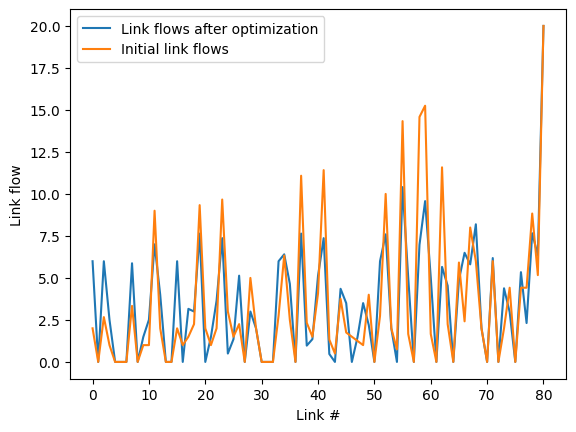

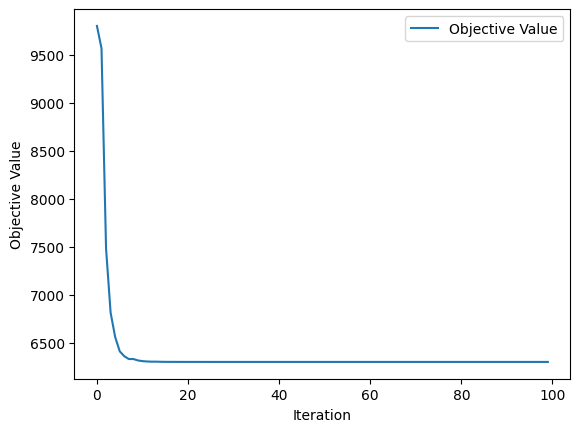

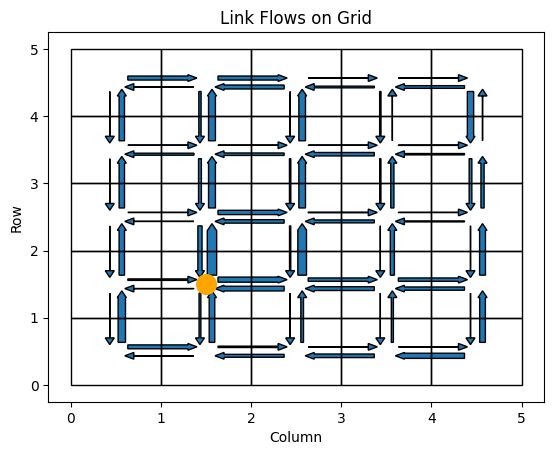

((1, 1),)
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 83, CG iterations: 521, optimality: 5.51e-03, constraint violation: 6.66e-15, execution time: 2.5e+01 s.


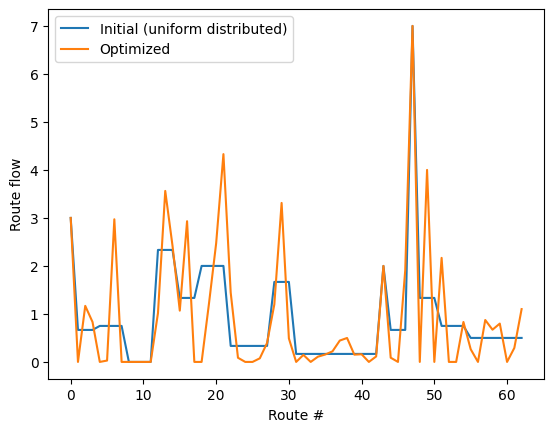

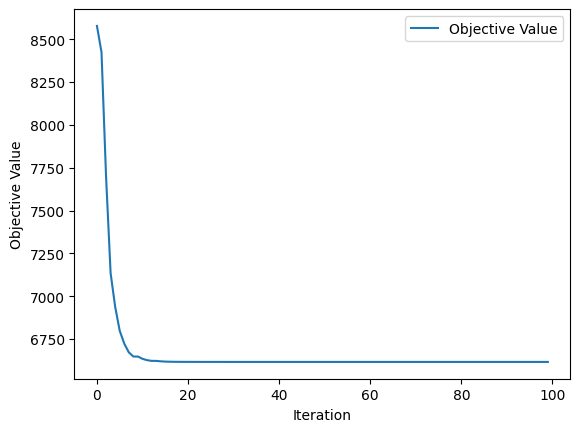

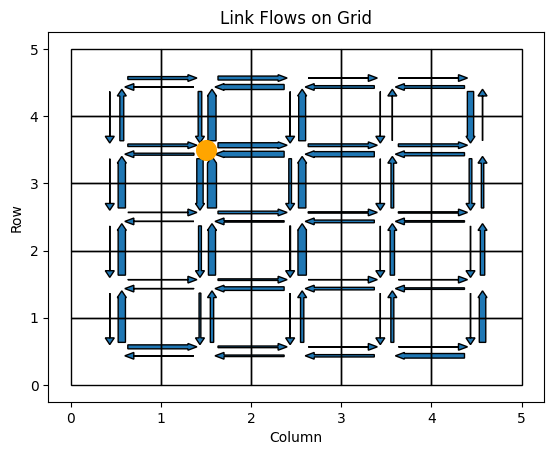

((4, 2),)
`gtol` termination condition is satisfied.
Number of iterations: 42, function evaluations: 33, CG iterations: 272, optimality: 6.43e-09, constraint violation: 9.41e-09, execution time: 2e+01 s.


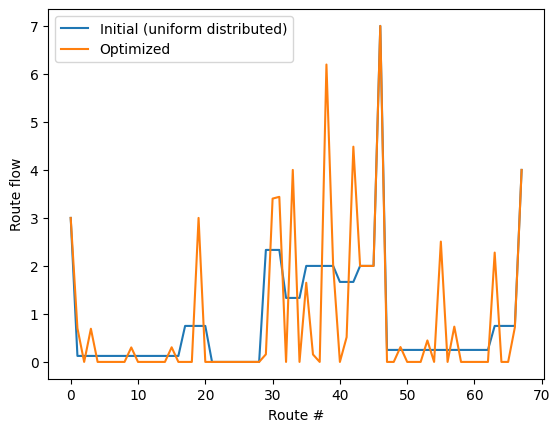

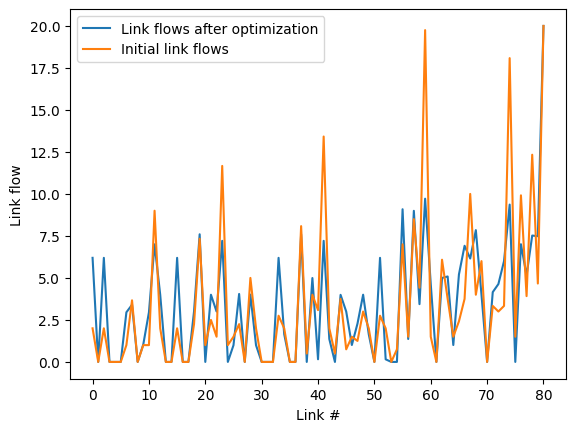

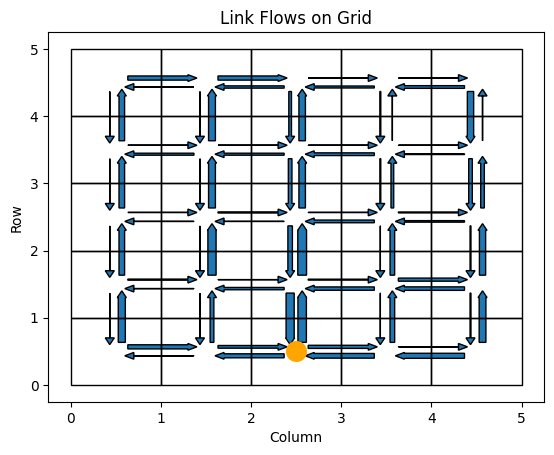

((3, 0),)


/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 101, CG iterations: 682, optimality: 2.08e-06, constraint violation: 8.88e-16, execution time: 3.6e+01 s.


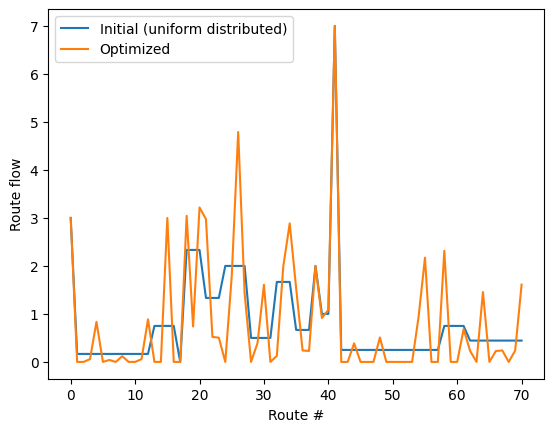

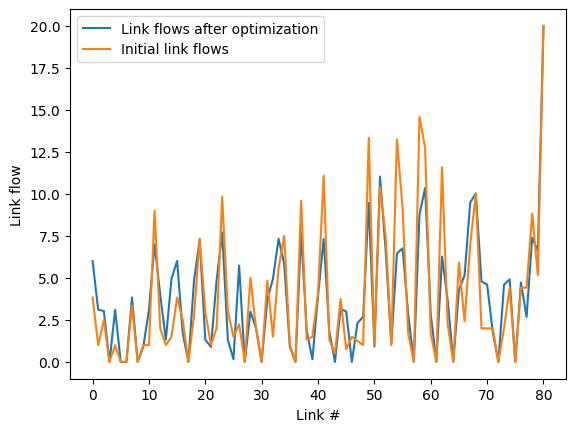

((2, 2),)
`gtol` termination condition is satisfied.
Number of iterations: 49, function evaluations: 40, CG iterations: 351, optimality: 1.77e-10, constraint violation: 2.40e-09, execution time: 1.7e+01 s.


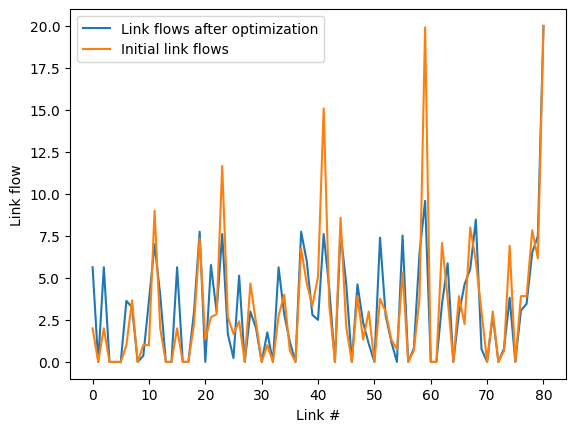

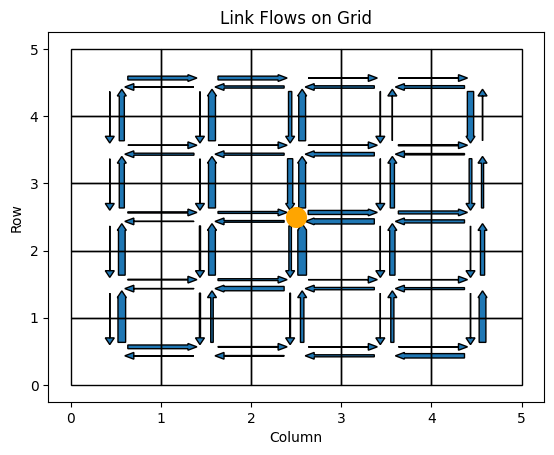

((3, 2),)
`gtol` termination condition is satisfied.
Number of iterations: 42, function evaluations: 33, CG iterations: 258, optimality: 8.35e-09, constraint violation: 4.77e-09, execution time: 1.9e+01 s.


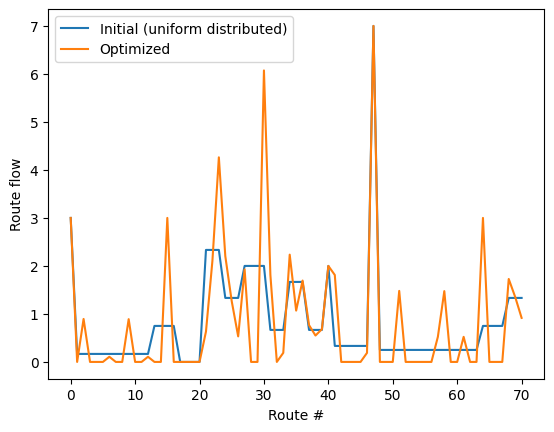

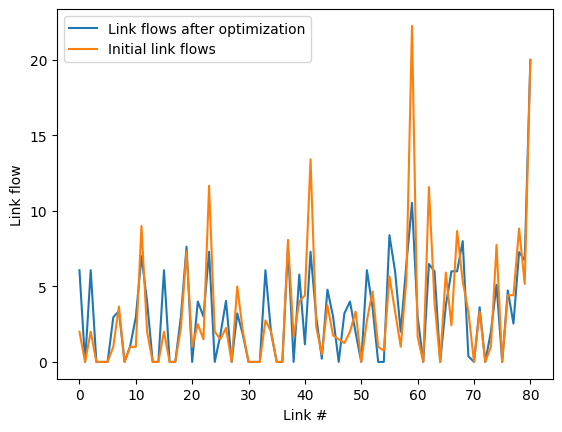

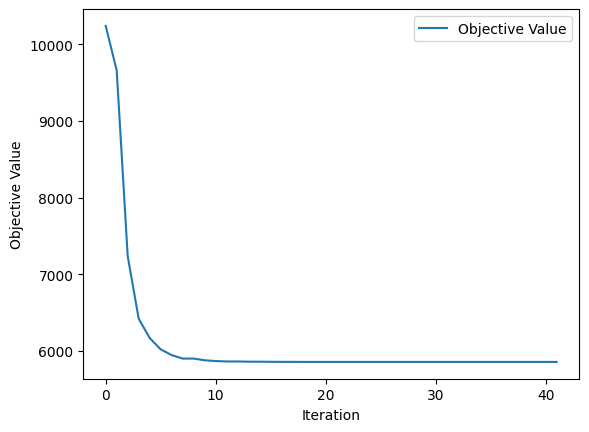

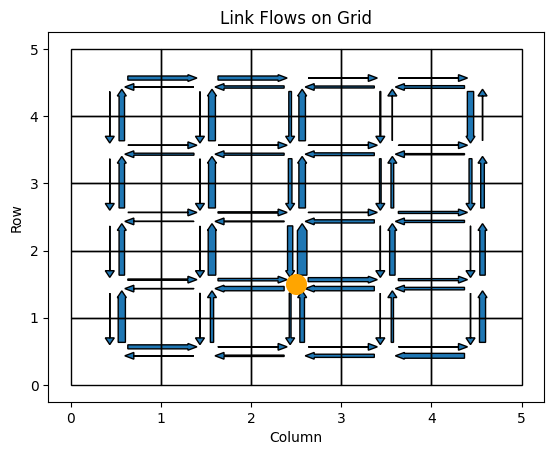

((4, 1),)
`gtol` termination condition is satisfied.
Number of iterations: 50, function evaluations: 41, CG iterations: 326, optimality: 1.11e-10, constraint violation: 2.18e-09, execution time: 2.6e+01 s.


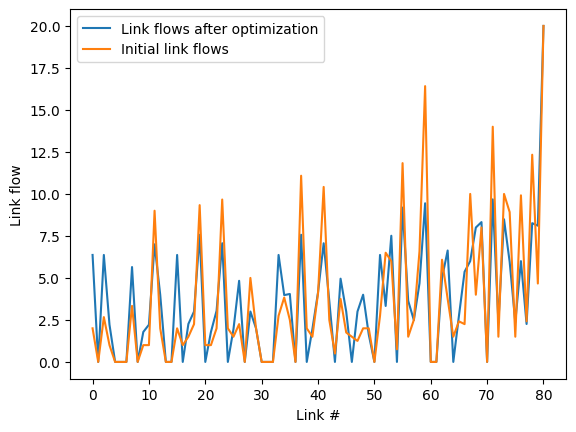

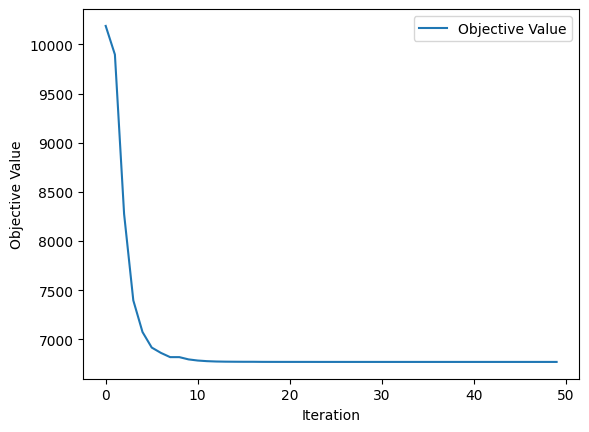

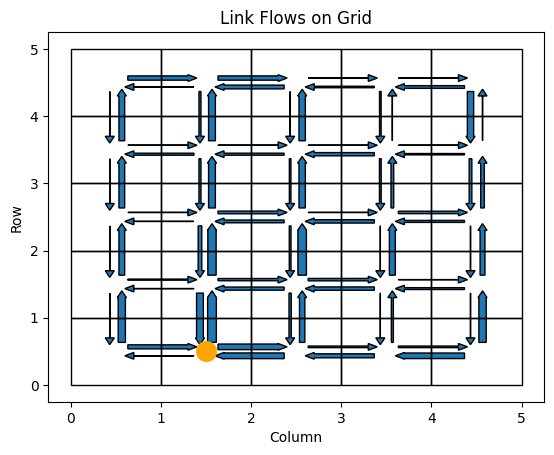

((1, 3), (4, 4))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 85, CG iterations: 698, optimality: 7.62e-03, constraint violation: 6.02e-15, execution time: 4.3e+01 s.


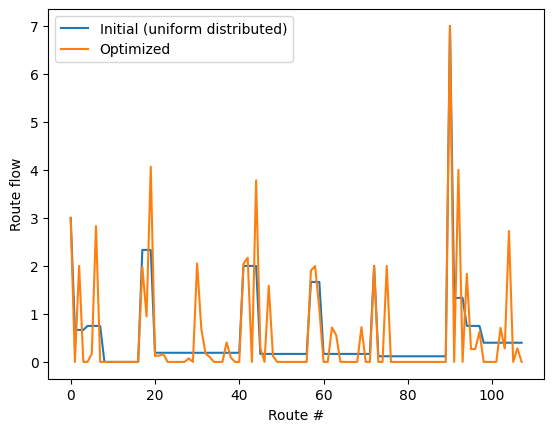

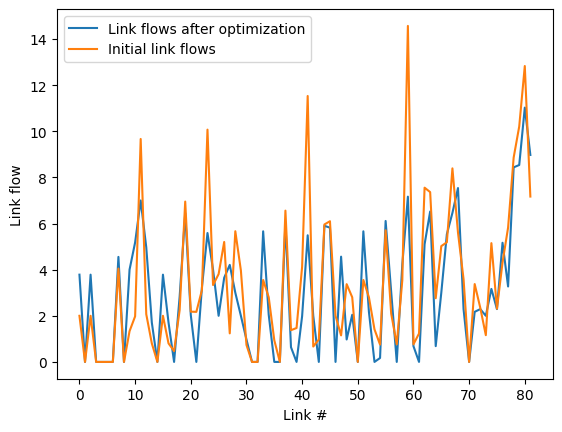

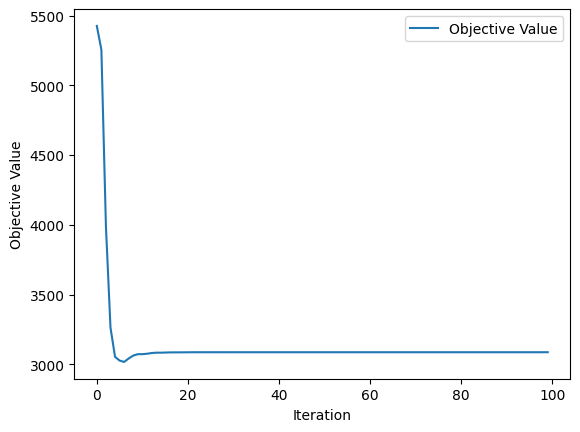

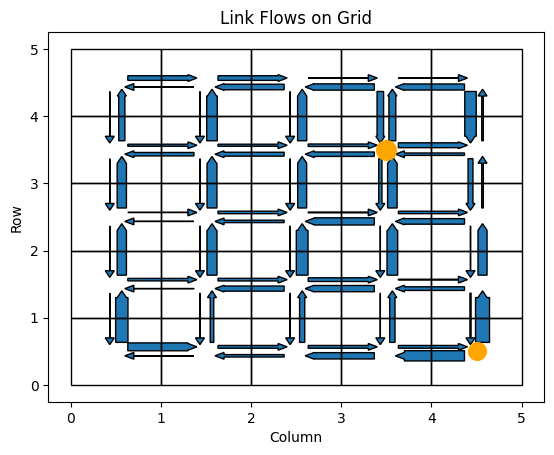

((1, 3), (0, 1))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 84, CG iterations: 809, optimality: 2.24e-03, constraint violation: 4.63e-15, execution time: 4.5e+01 s.


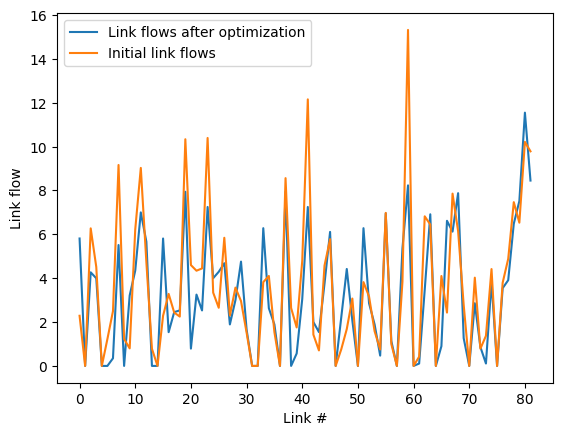

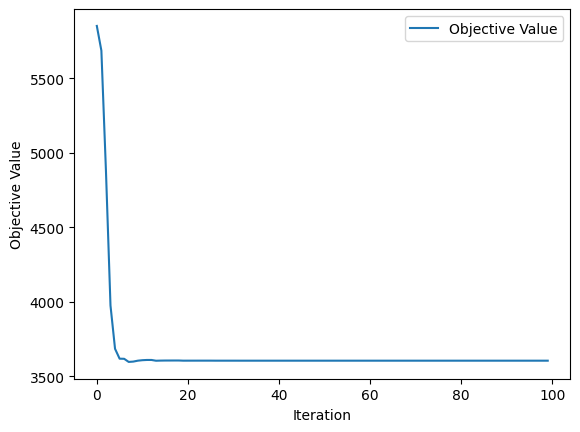

((1, 3), (3, 1))
`gtol` termination condition is satisfied.
Number of iterations: 49, function evaluations: 40, CG iterations: 478, optimality: 9.31e-09, constraint violation: 3.67e-09, execution time: 2.6e+01 s.


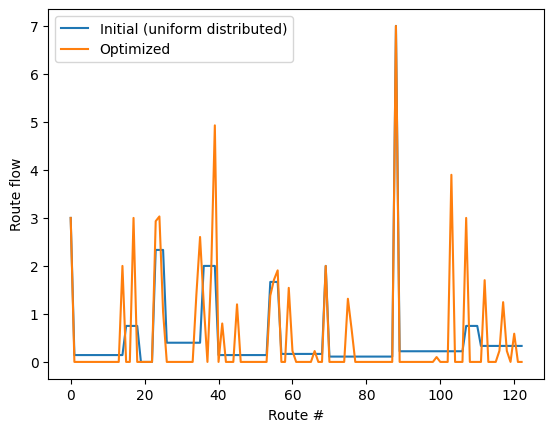

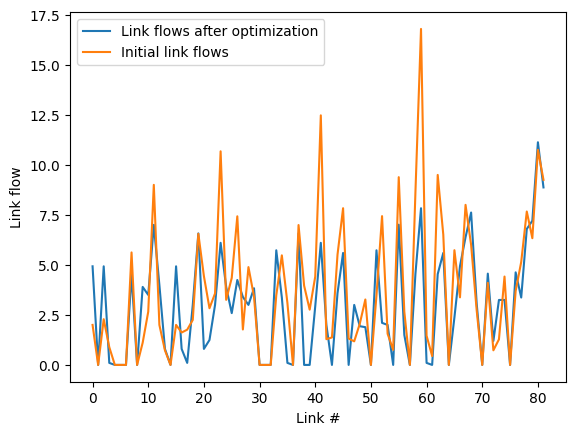

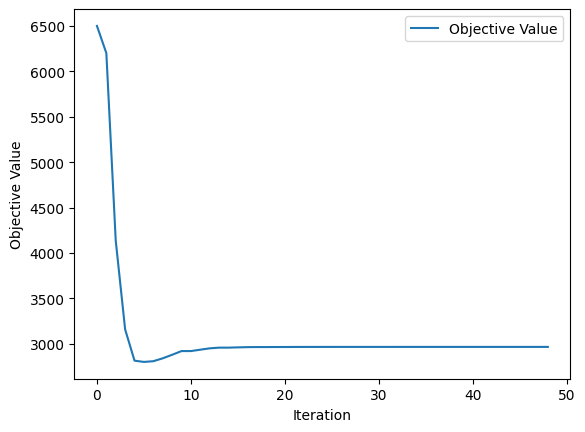

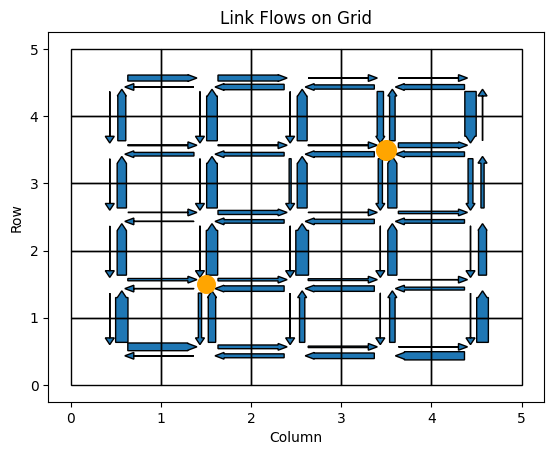

((1, 3), (1, 1))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 89, CG iterations: 1002, optimality: 7.34e-04, constraint violation: 4.72e-15, execution time: 4.1e+01 s.


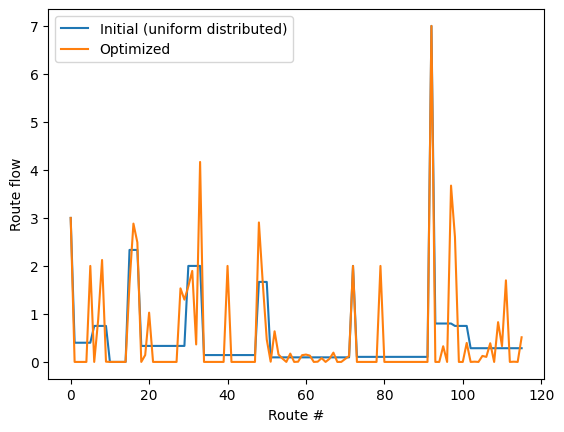

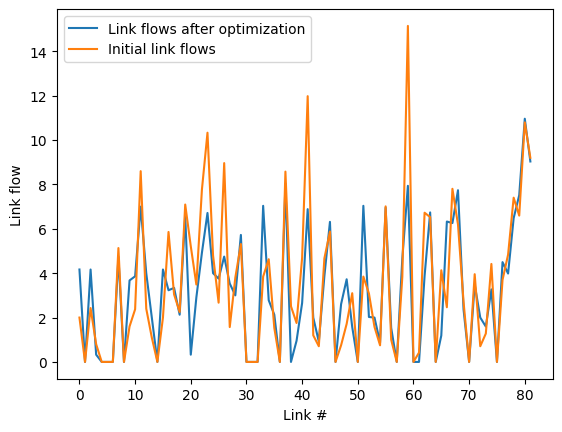

((1, 3), (4, 2))
`gtol` termination condition is satisfied.
Number of iterations: 50, function evaluations: 41, CG iterations: 446, optimality: 1.38e-09, constraint violation: 1.81e-09, execution time: 2.7e+01 s.


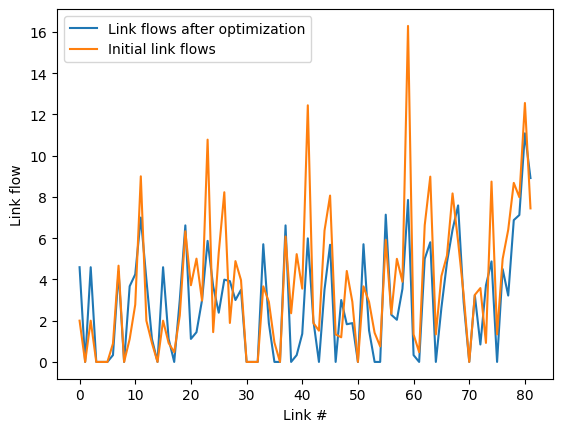

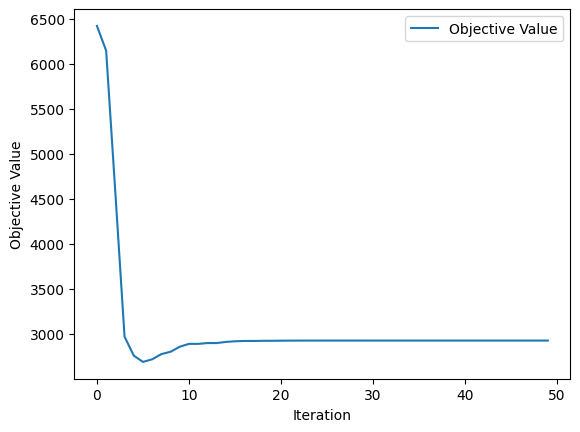

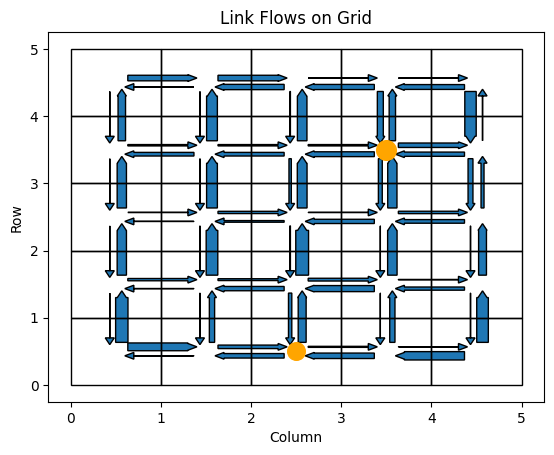

((1, 3), (3, 0))
`gtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 36, CG iterations: 534, optimality: 5.29e-09, constraint violation: 1.85e-09, execution time: 2.4e+01 s.


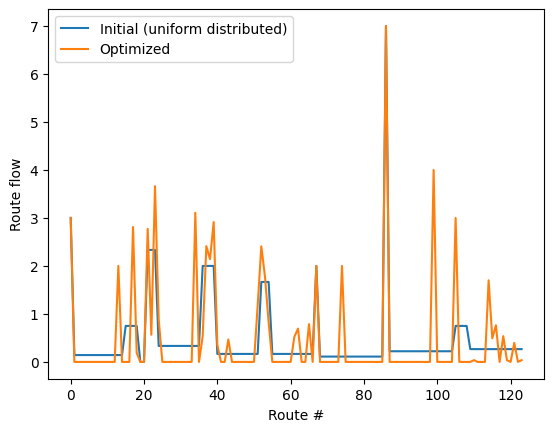

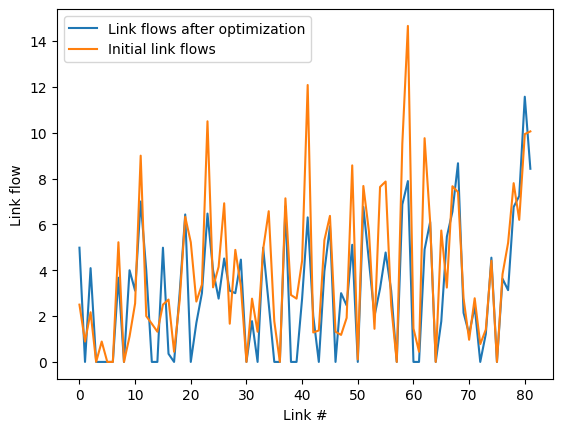

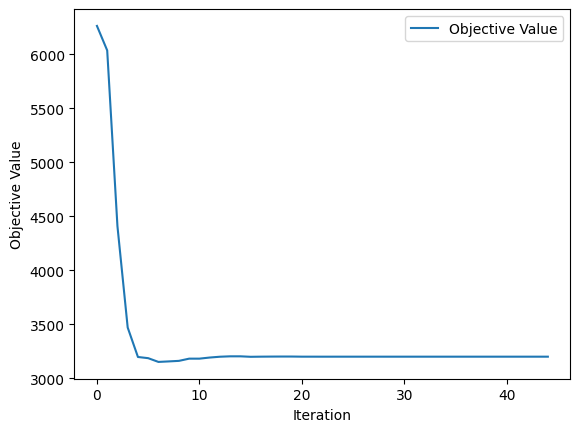

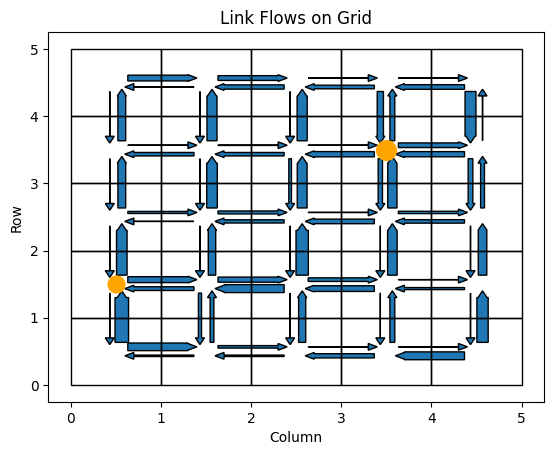

((1, 3), (2, 2))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 84, CG iterations: 696, optimality: 3.23e-04, constraint violation: 3.55e-15, execution time: 4.2e+01 s.


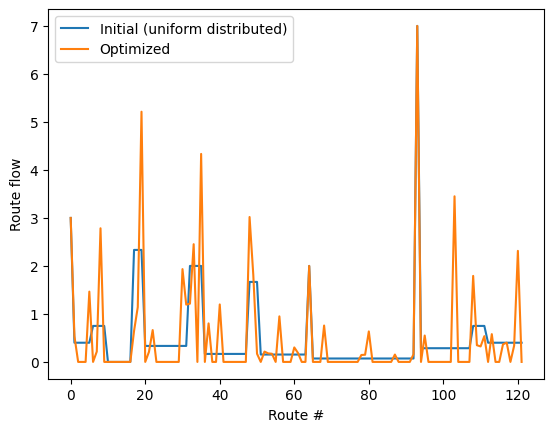

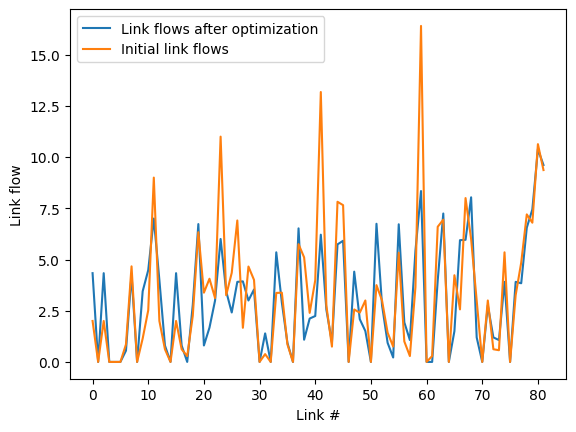

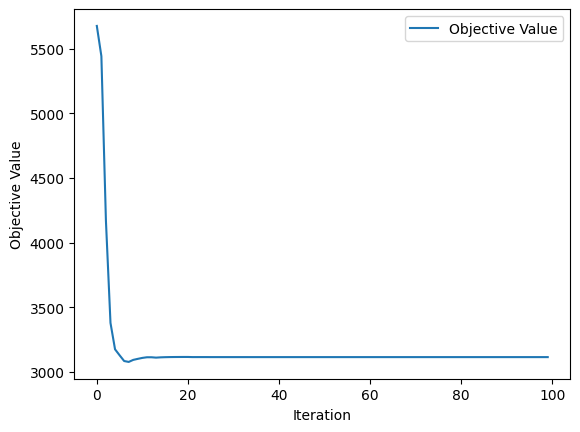

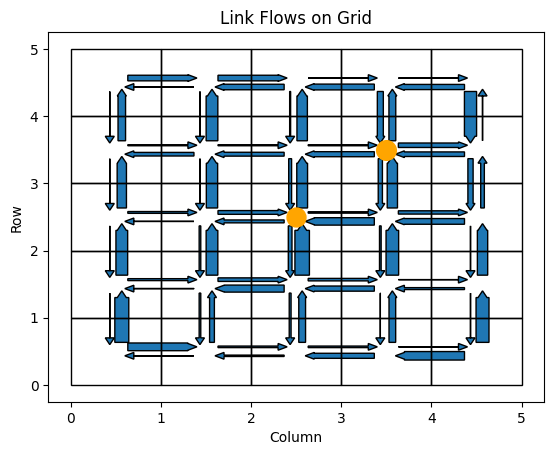

((1, 3), (3, 2))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 82, CG iterations: 532, optimality: 2.66e-04, constraint violation: 6.22e-15, execution time: 4.3e+01 s.


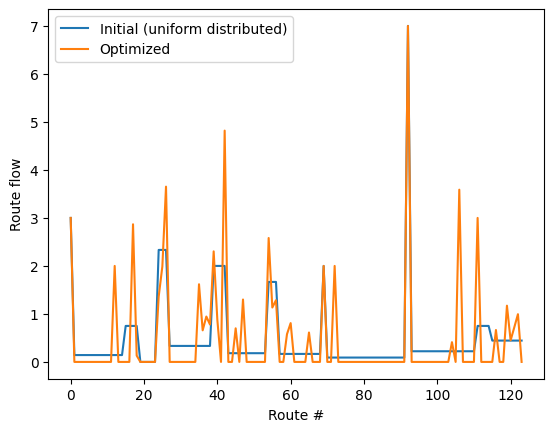

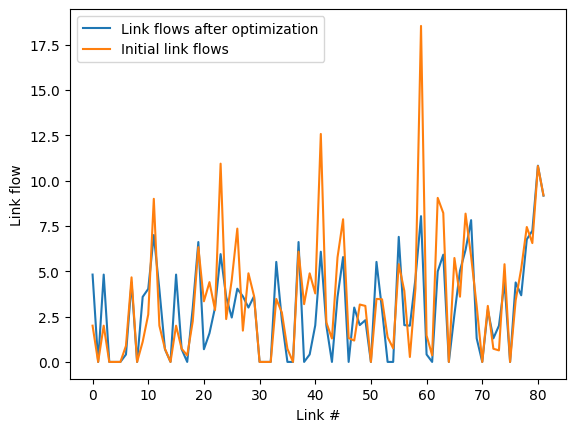

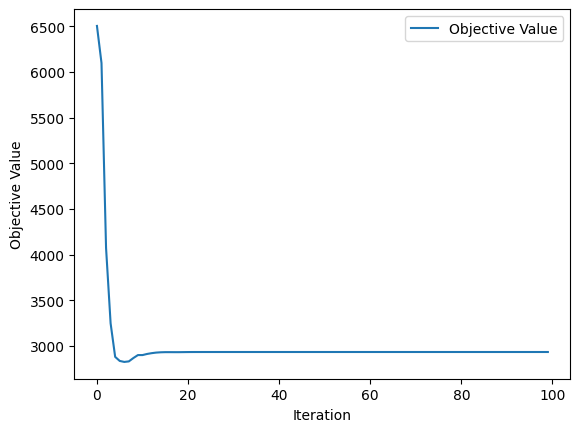

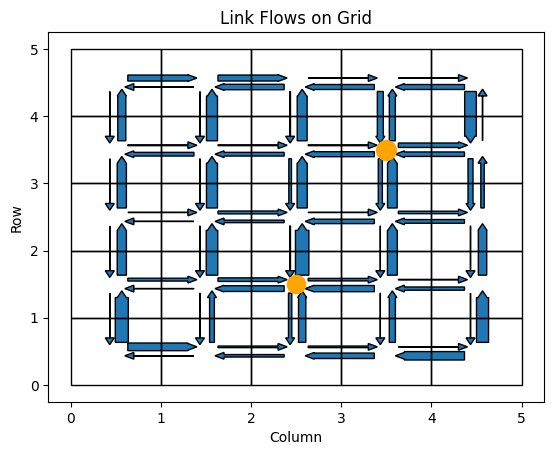

((1, 3), (4, 1))
`gtol` termination condition is satisfied.
Number of iterations: 53, function evaluations: 44, CG iterations: 592, optimality: 9.56e-10, constraint violation: 6.93e-09, execution time: 2.8e+01 s.


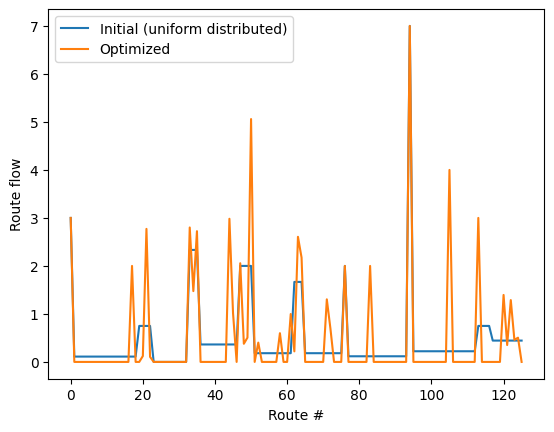

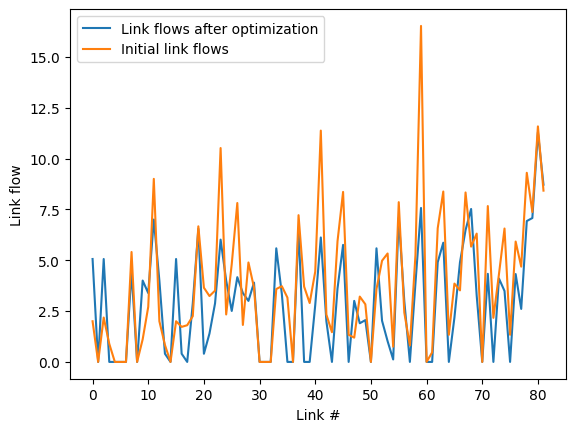

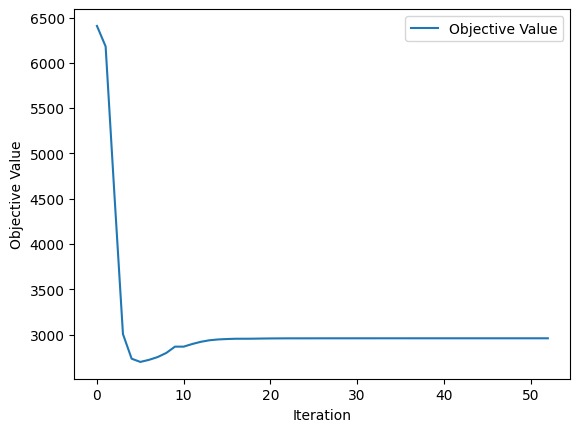

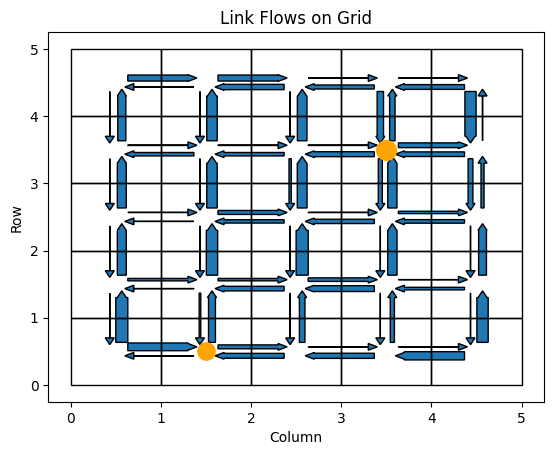

((1, 3), (4, 2), (4, 4))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 82, CG iterations: 835, optimality: 3.40e-03, constraint violation: 4.98e-14, execution time: 4.8e+01 s.


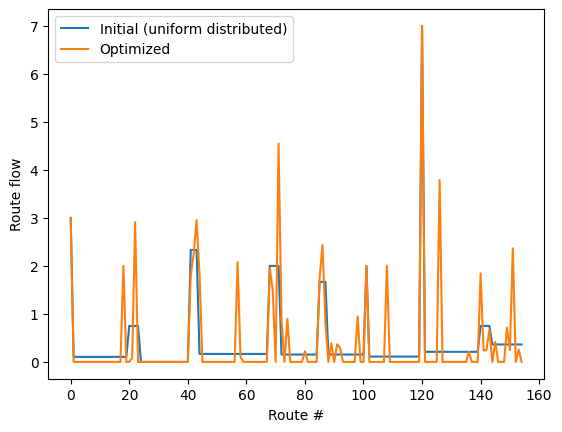

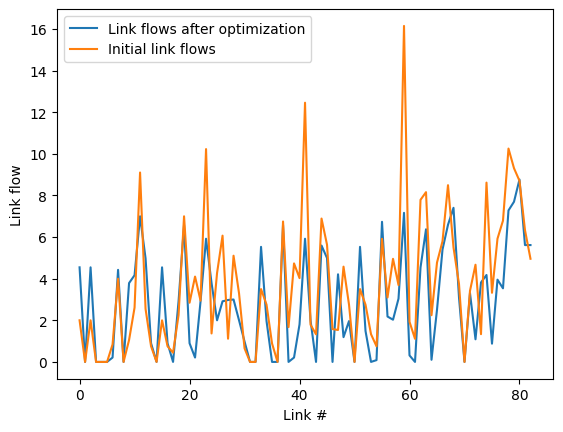

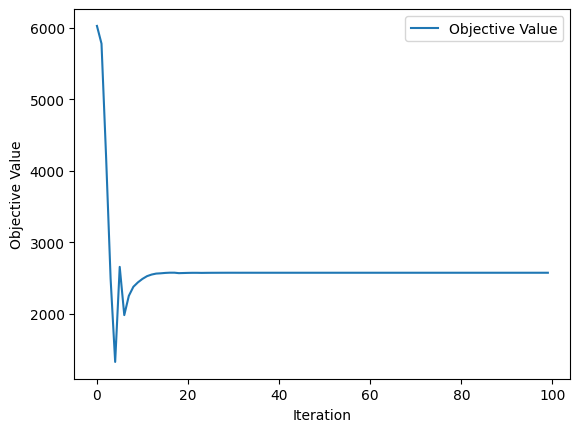

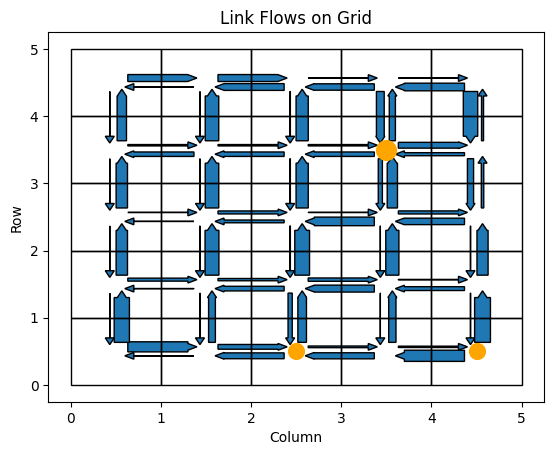

((1, 3), (4, 2), (0, 1))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 87, CG iterations: 668, optimality: 3.50e-03, constraint violation: 2.21e-14, execution time: 4.5e+01 s.


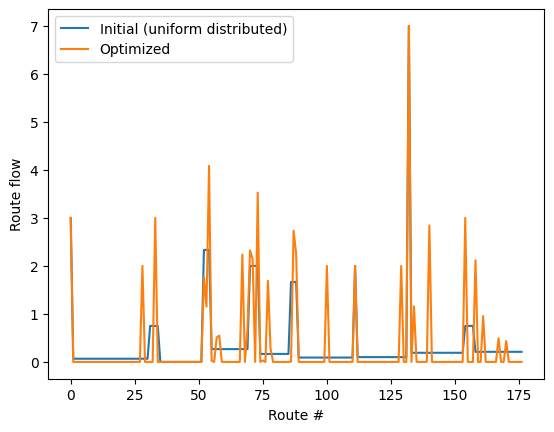

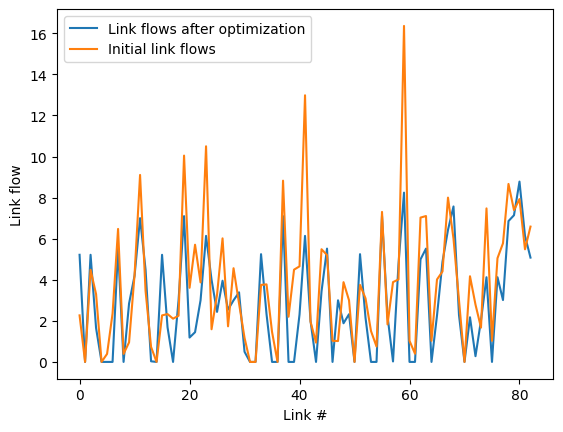

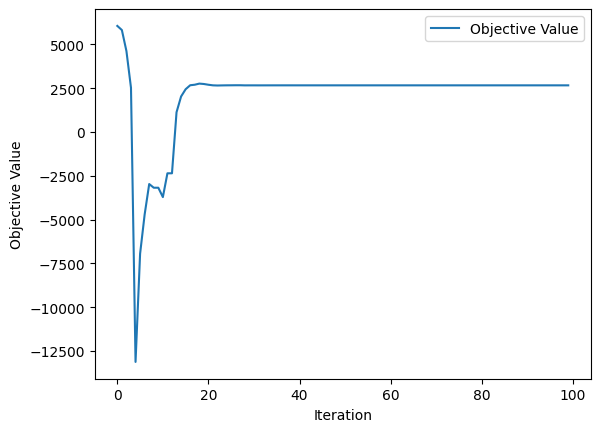

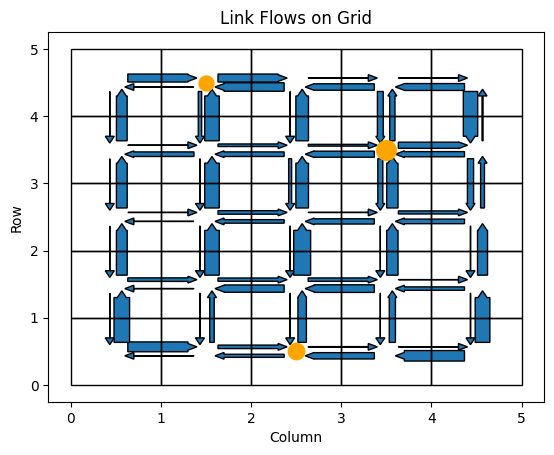

((1, 3), (4, 2), (3, 1))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 83, CG iterations: 774, optimality: 2.31e-02, constraint violation: 4.21e-15, execution time: 4.7e+01 s.


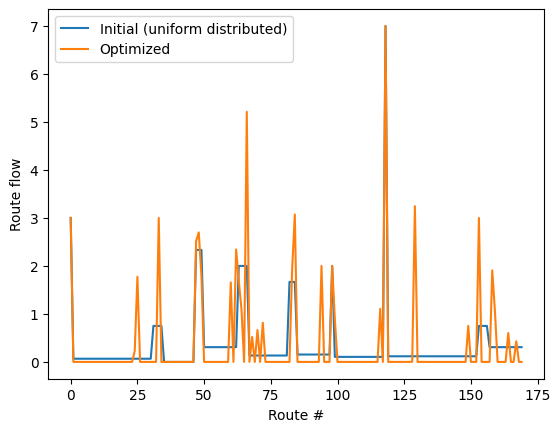

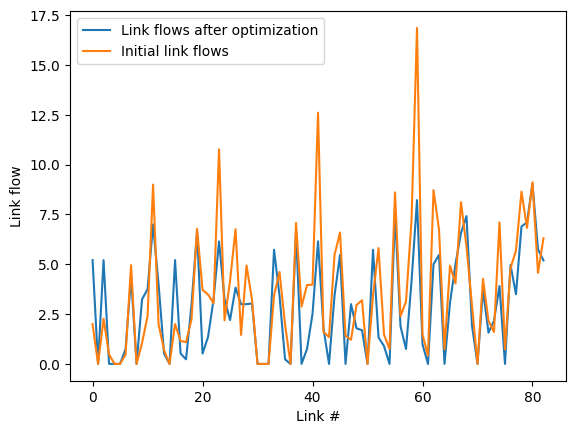

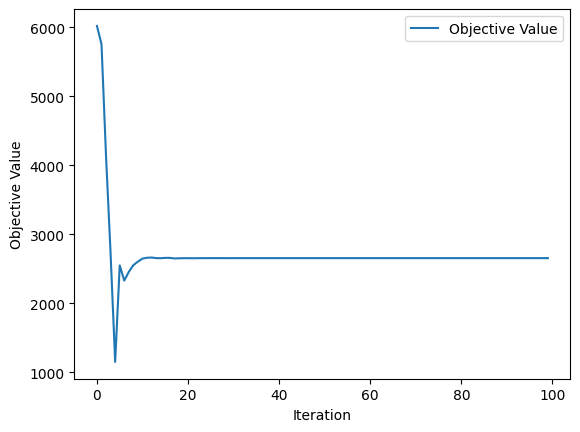

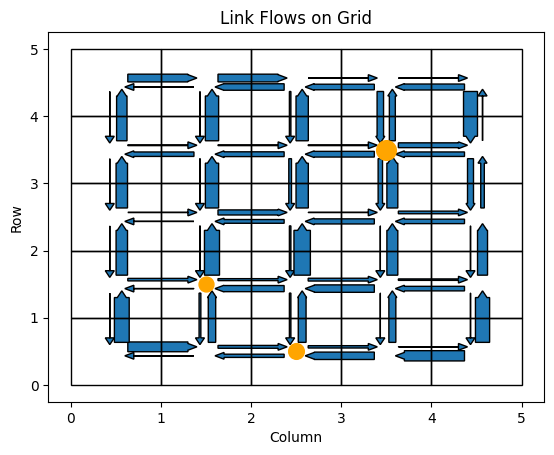

((1, 3), (4, 2), (1, 1))
`gtol` termination condition is satisfied.
Number of iterations: 64, function evaluations: 55, CG iterations: 870, optimality: 8.85e-09, constraint violation: 4.49e-09, execution time: 3.4e+01 s.


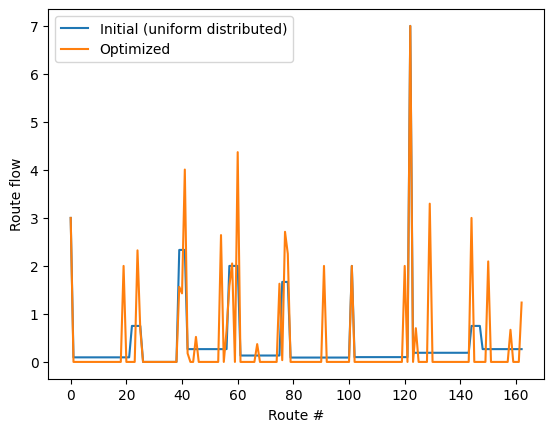

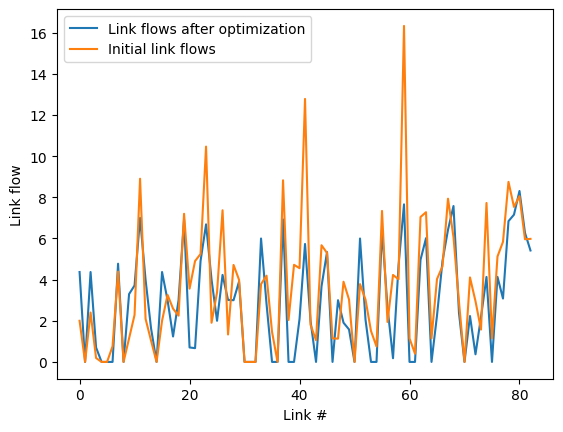

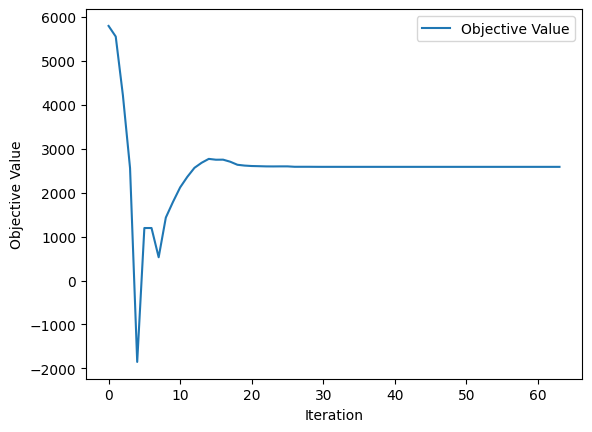

((1, 3), (4, 2), (3, 0))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 83, CG iterations: 734, optimality: 2.41e-03, constraint violation: 4.44e-15, execution time: 4.5e+01 s.


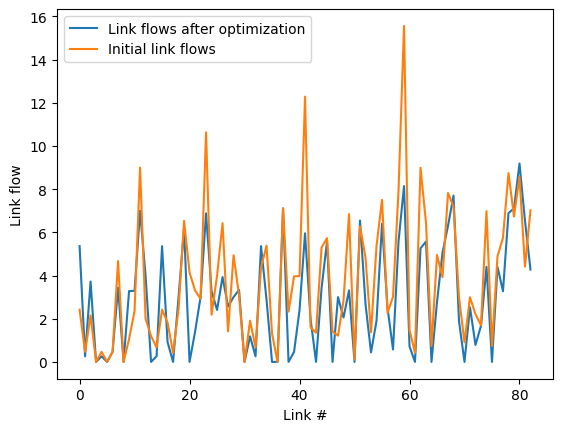

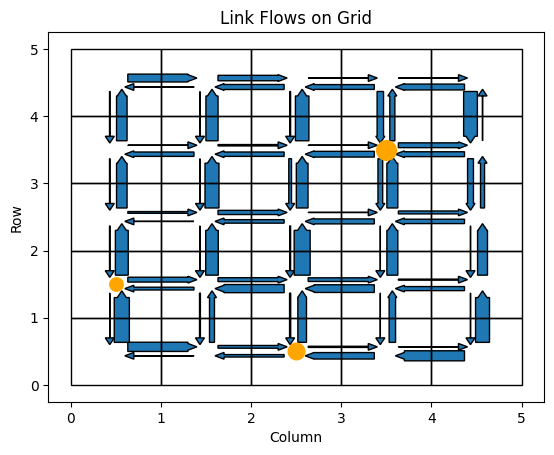

((1, 3), (4, 2), (2, 2))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 83, CG iterations: 808, optimality: 4.58e-03, constraint violation: 2.25e-14, execution time: 4.4e+01 s.


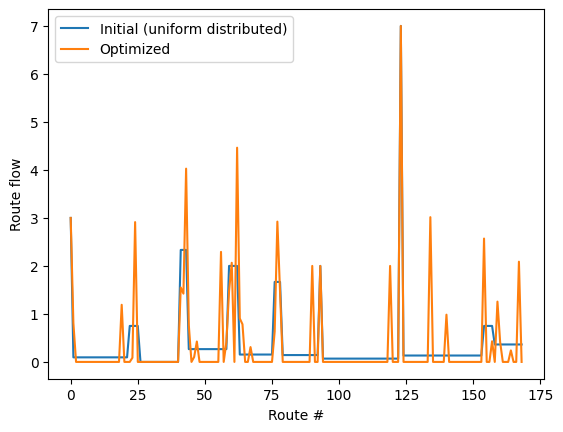

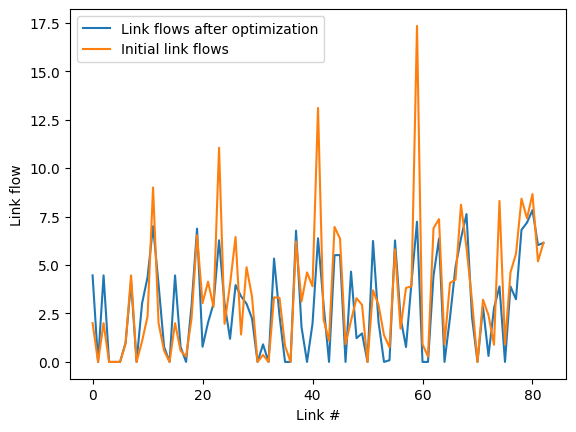

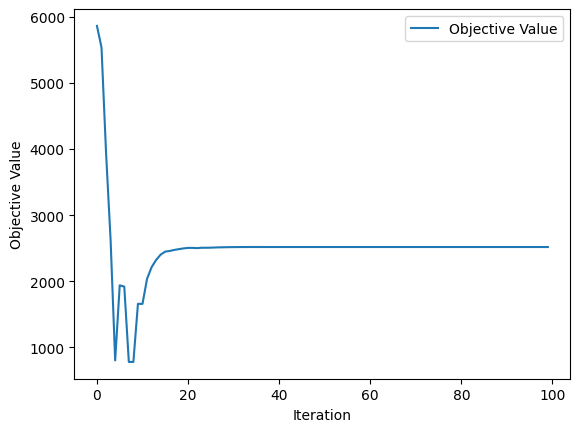

((1, 3), (4, 2), (3, 2))
`gtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 58, CG iterations: 843, optimality: 3.84e-09, constraint violation: 2.11e-09, execution time: 3.5e+01 s.


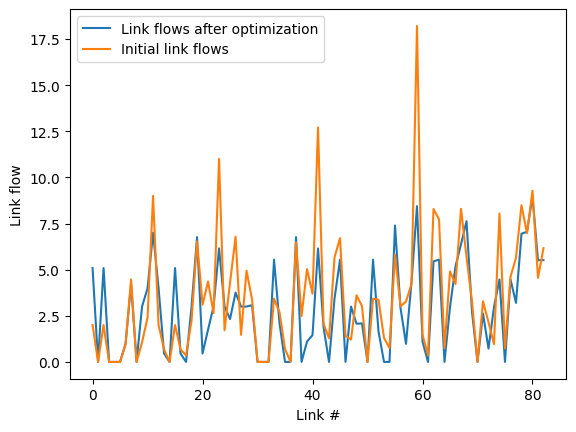

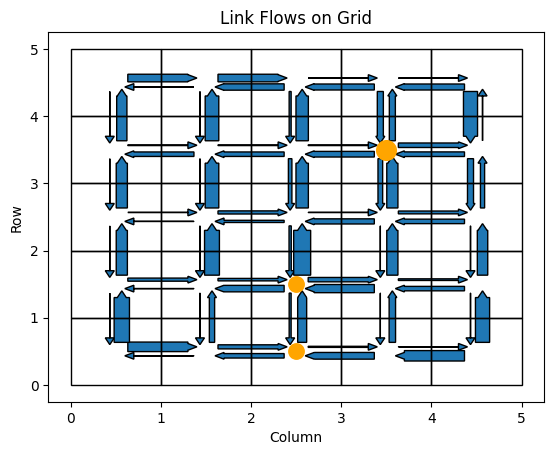

((1, 3), (4, 2), (4, 1))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 83, CG iterations: 910, optimality: 2.32e-02, constraint violation: 6.22e-15, execution time: 5.1e+01 s.


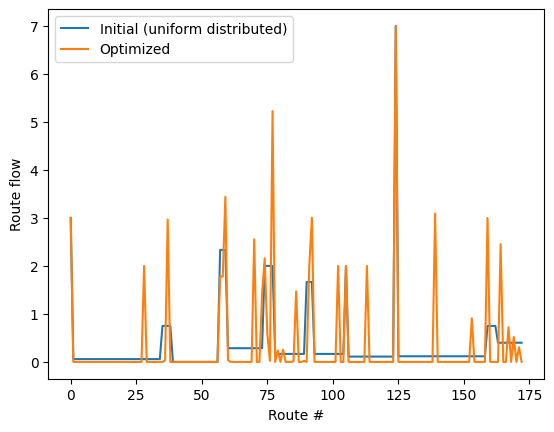

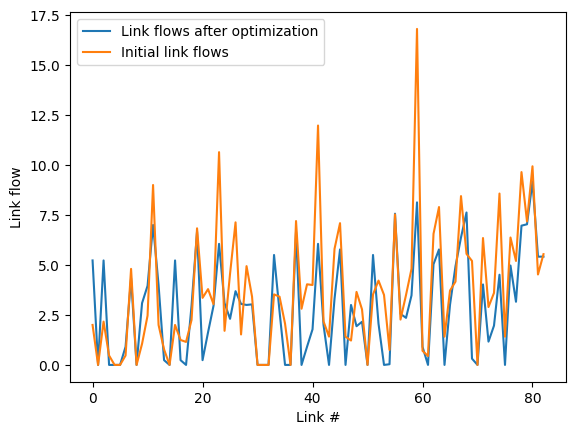

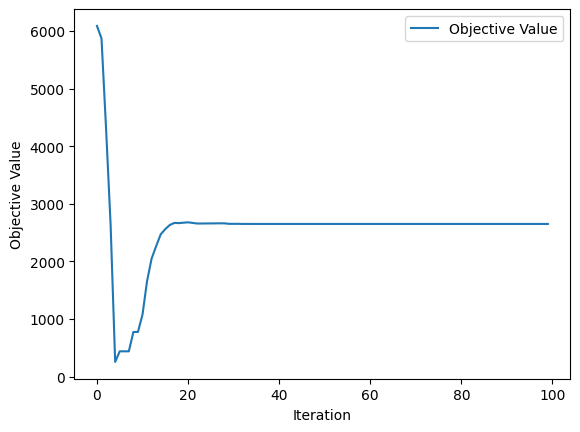

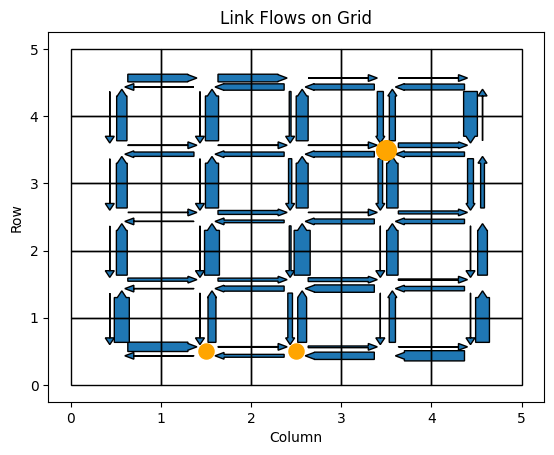

((1, 3), (4, 2), (2, 2), (4, 4))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 84, CG iterations: 1237, optimality: 4.08e-02, constraint violation: 1.10e-14, execution time: 5.3e+01 s.


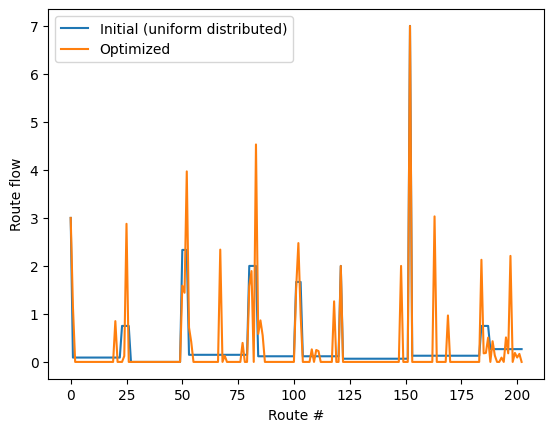

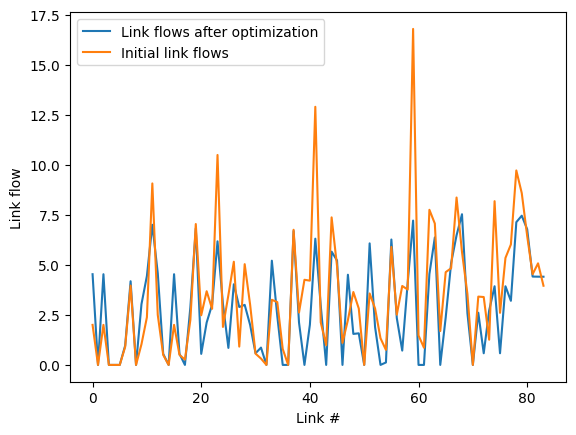

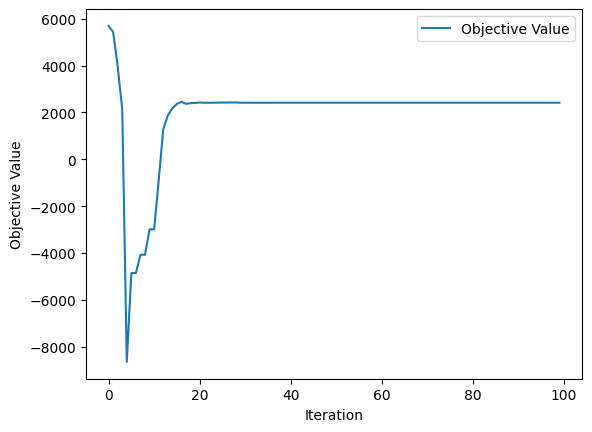

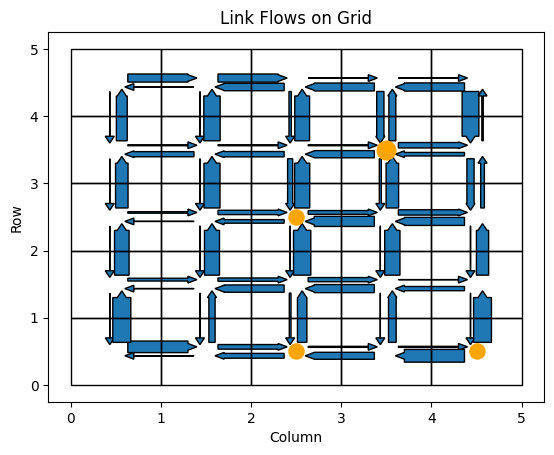

((1, 3), (4, 2), (2, 2), (0, 1))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 101, CG iterations: 1662, optimality: 2.60e-03, constraint violation: 2.98e-14, execution time: 4.7e+01 s.


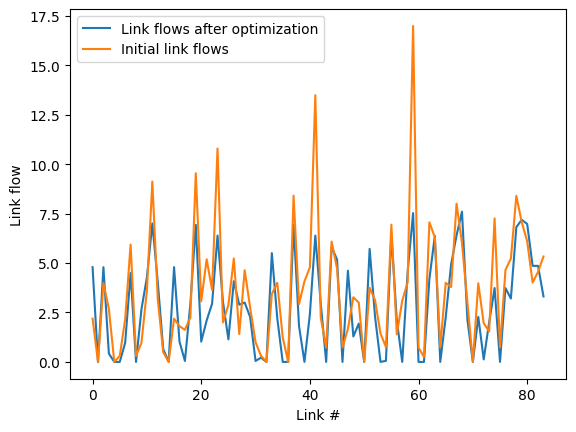

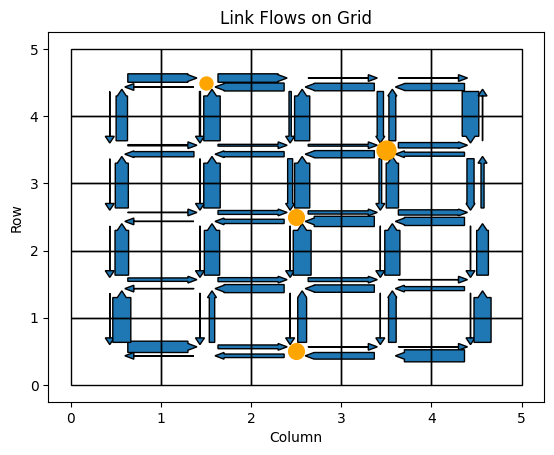

((1, 3), (4, 2), (2, 2), (3, 1))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 85, CG iterations: 895, optimality: 1.68e-03, constraint violation: 8.88e-15, execution time: 4.7e+01 s.


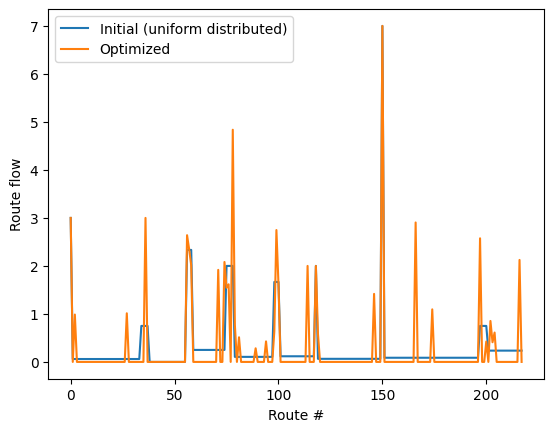

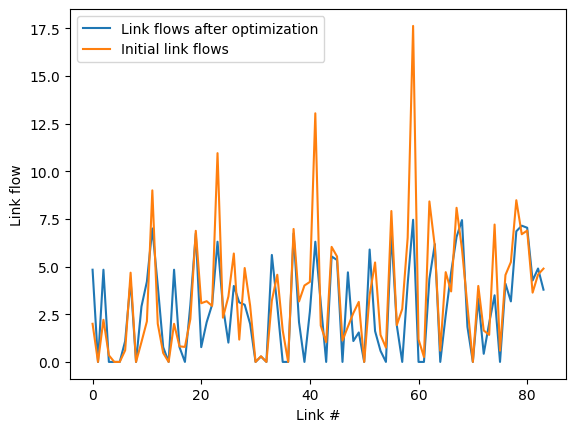

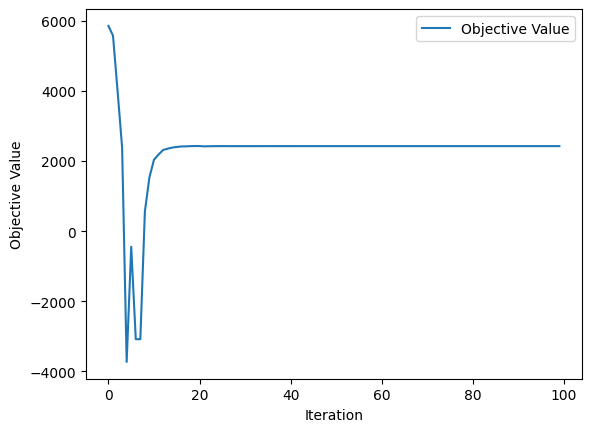

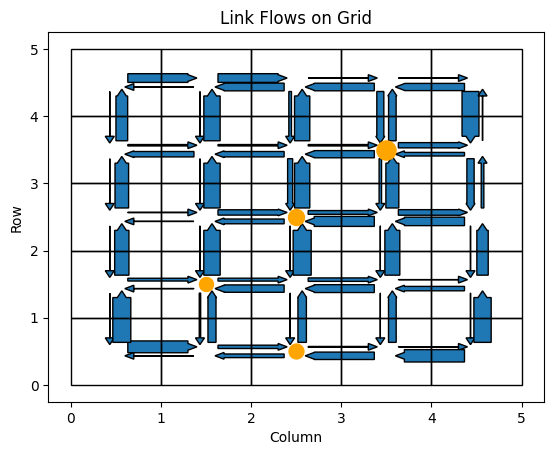

((1, 3), (4, 2), (2, 2), (1, 1))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 86, CG iterations: 1267, optimality: 4.60e-03, constraint violation: 2.93e-14, execution time: 4.4e+01 s.


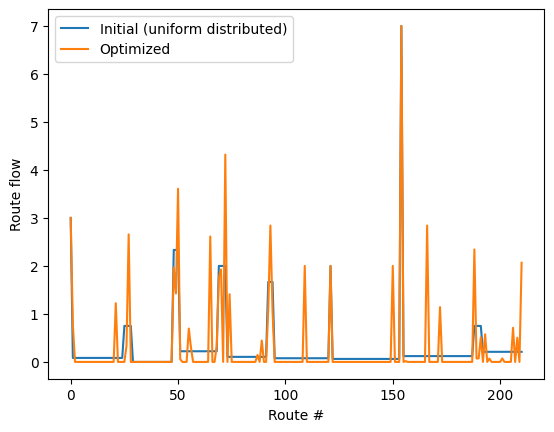

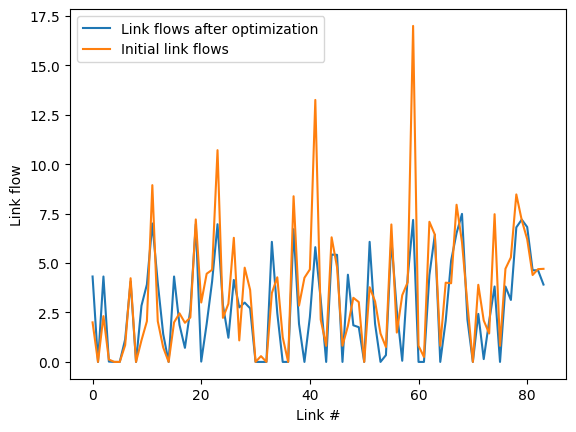

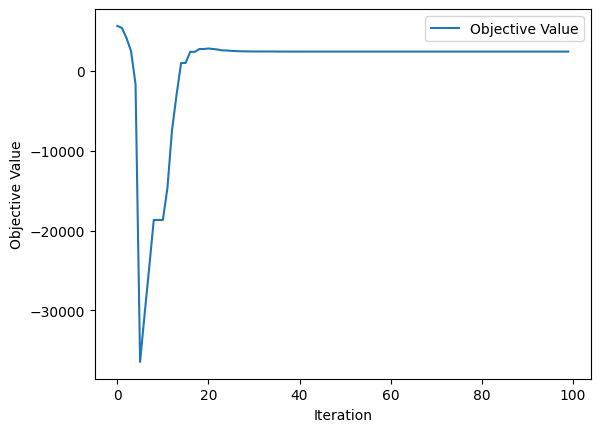

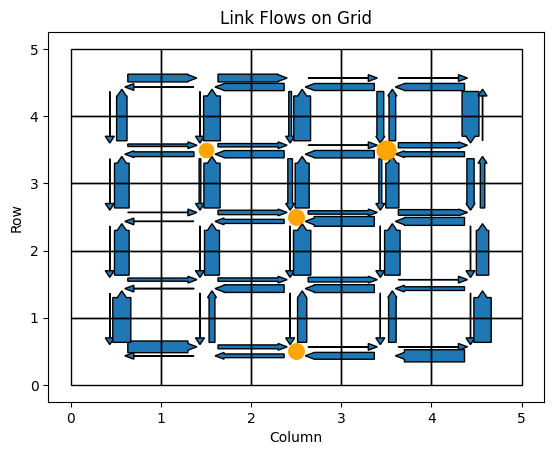

((1, 3), (4, 2), (2, 2), (3, 0))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 83, CG iterations: 876, optimality: 5.78e-03, constraint violation: 8.17e-15, execution time: 4.6e+01 s.


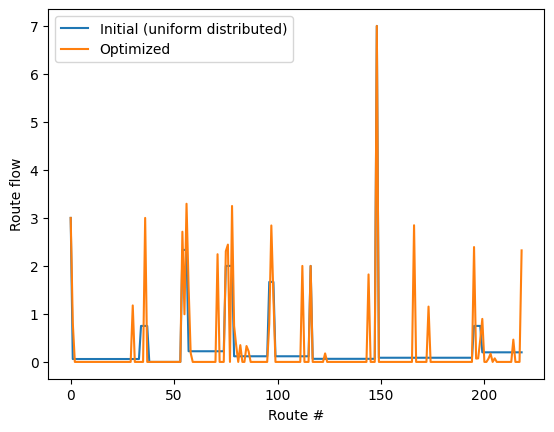

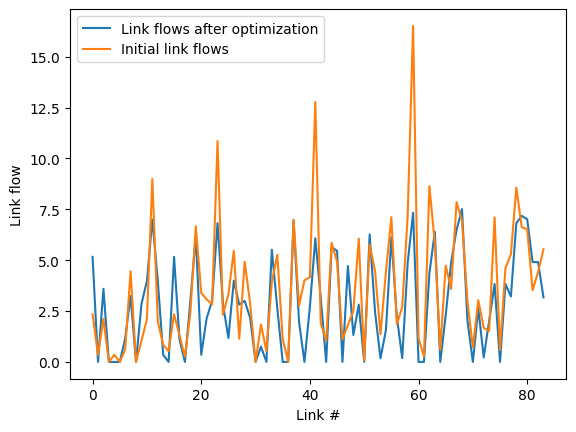

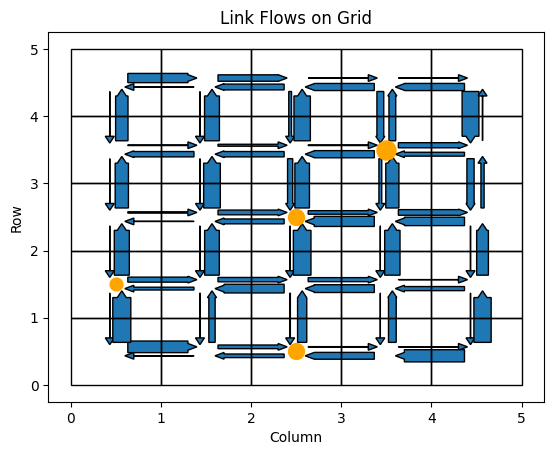

((1, 3), (4, 2), (2, 2), (3, 2))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 90, CG iterations: 1288, optimality: 1.02e-02, constraint violation: 8.30e-14, execution time: 5.4e+01 s.


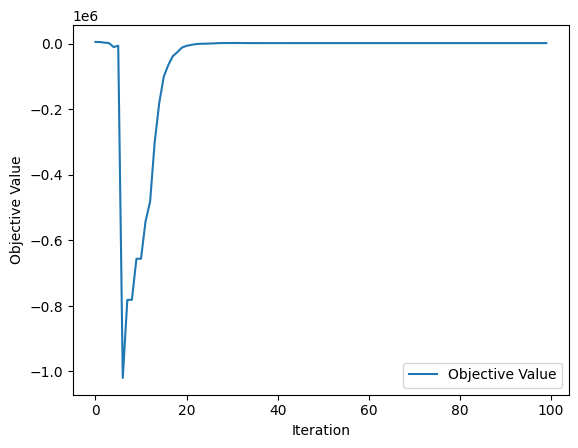

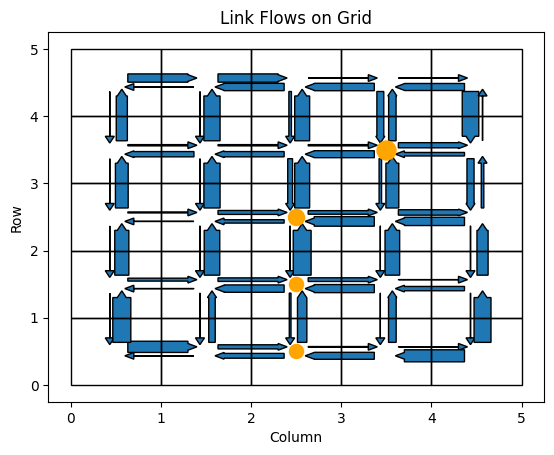

((1, 3), (4, 2), (2, 2), (4, 1))
The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 83, CG iterations: 1073, optimality: 3.03e-02, constraint violation: 1.36e-14, execution time: 4.8e+01 s.


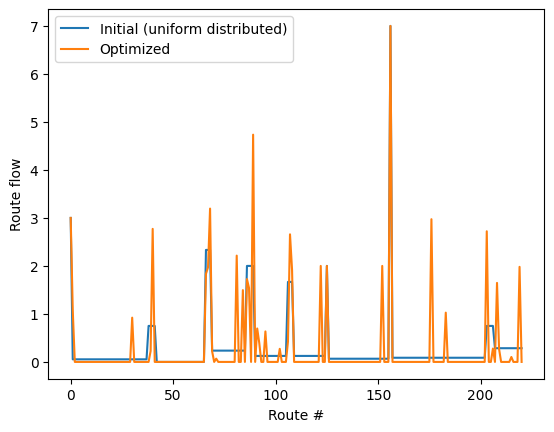

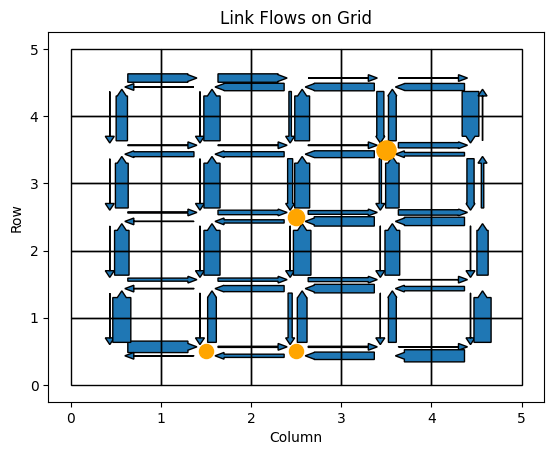

Min Travel Time:  6984.888058106827 using chargers:  ((1, 3), (4, 2), (2, 2), (1, 1))
Possible charger positions:  {(4, 4), (1, 3), (0, 1), (3, 1), (1, 1), (4, 2), (3, 0), (2, 2), (3, 2), (4, 1)}


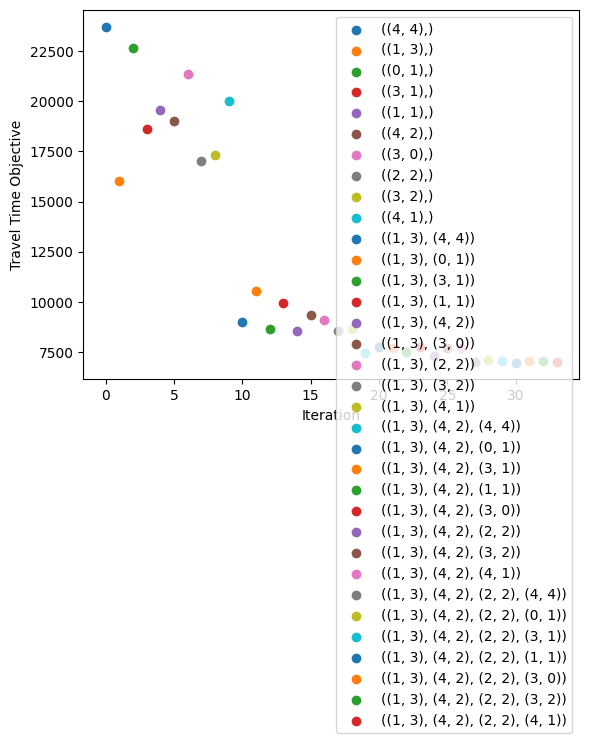

In [55]:
grids2 = outer_optimization(n=n, d=d, possible_charger_positions=possible_charger_positions, num_chargers=num_chargers)

Min Travel Time:  6984.888058106827 using chargers:  ((1, 3), (4, 2), (2, 2), (1, 1))


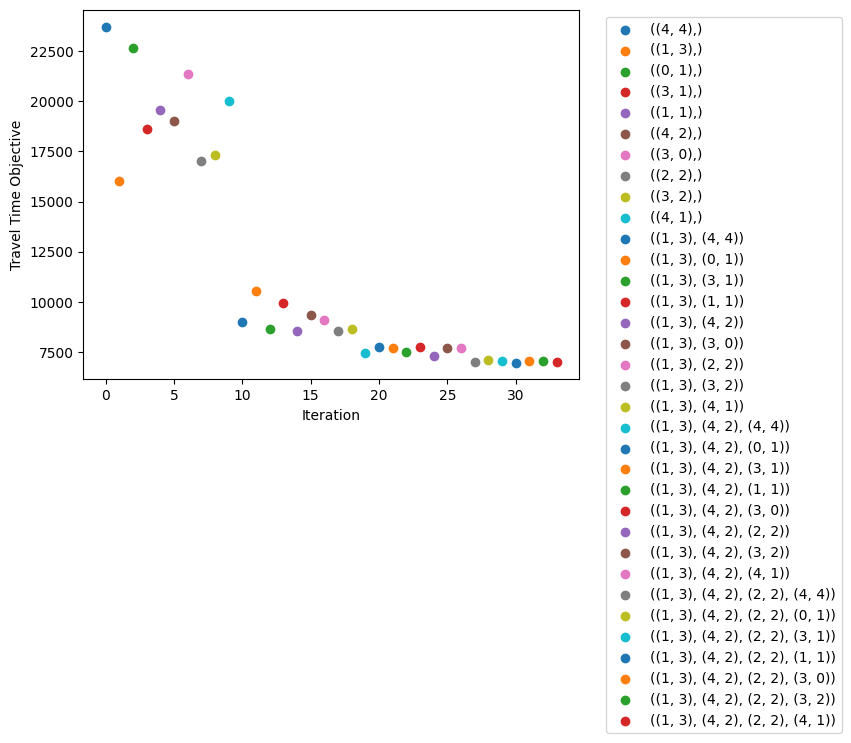

In [62]:
plot_travel_time_objectives(grids2)